### Data ingection and structuring layer

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Tuple
from datetime import datetime
import networkx as nx
import warnings

warnings.filterwarnings('ignore')

#  
# CONFIGURATION
#  

BASE_PATH = Path(r"C:\Users\adars\Downloads\stm-model")

ORDERS_PATH = BASE_PATH / "Orders"
TRADES_PATH = BASE_PATH / "Trades"
SUSPICIOUS_ORDERS_PATH = BASE_PATH / "Suspicious-list" / "Orders"
SUSPICIOUS_TRADES_PATH = BASE_PATH / "Suspicious-list" / "Trades"


#  
# GENERIC LOADER FUNCTION
#  

def load_files(folder_path: Path, pattern: str, reader_func, **reader_kwargs) -> pd.DataFrame:
    """
    Generic loader to read and concatenate multiple files.
    """
    files: List[Path] = list(folder_path.glob(pattern))
    
    if not files:
        raise FileNotFoundError(f"No files found in {folder_path} with pattern {pattern}")

    df_list = []
    
    for file in files:
        try:
            print(f"Reading: {file.name}")
            df = reader_func(file, **reader_kwargs)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file.name}: {e}")
    
    if not df_list:
        raise ValueError(f"No valid files could be read from {folder_path}")

    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Total records loaded from {folder_path.name}: {len(combined_df):,}")
    
    return combined_df


#  
# LOAD ORDERS
#  

orders_df = load_files(
    ORDERS_PATH,
    "*.xls",
    pd.read_excel,
    engine="xlrd"
)

# Standardize Orders column names
orders_rename = {
    'Scrip Code': 'SCRIP_CODE',
    'Member Code': 'MEMBER_CODE',
    'Client Code': 'CLIENT_CODE',
    'Order Qunatity': 'ORDER_QUANTITY',  # Handle typo in source
    'value': 'ORDER_VALUE',
    'Order Type': 'ORDER_TYPE',
    'Buy/Sell Flag': 'BUY_SELL_FLAG',
    'Terminal No': 'TERMINAL_NO',
    'Location Id': 'LOCATION_ID',
    'ORDER_NUMBER': 'ORDER_NUMBER',
    'ORDER_DATE': 'ORDER_DATE',
    'Order Time': 'ORDER_TIME'
}
orders_df.rename(columns=orders_rename, inplace=True)
orders_df.columns = orders_df.columns.str.strip()


#  
# LOAD TRADES
#  

trades_df = load_files(
    TRADES_PATH,
    "*.xls",
    pd.read_excel,
    engine="xlrd"
)

# Standardize Trades column names  
trades_rename = {
    'Buy Client Code': 'BUY_CLIENT_CODE',
    'Sell Client Code': 'SELL_CLIENT_CODE'
}
trades_df.rename(columns=trades_rename, inplace=True)
trades_df = trades_df.astype({col: 'str' for col in ['BUY_CLIENT_CODE', 'SELL_CLIENT_CODE'] if col in trades_df.columns})


#  
# LOAD SUSPICIOUS LIST (Flagged Scrips & Clients)
#  

suspicious_df = load_files(
    SUSPICIOUS_ORDERS_PATH,
    "*.csv",
    pd.read_csv
)

# Standardize Suspicious list columns
suspicious_df.columns = suspicious_df.columns.str.strip().str.upper()
suspicious_df = suspicious_df[['SCRIP_CODE', 'BIG_ORD_CLIENT_ID', 'BIG_ORD_MEMBER_CODE']].drop_duplicates()


#  
# BASIC DATA QUALITY CHECKS
#  

def basic_quality_checks(df: pd.DataFrame, name: str):
    print(f"\n{name} Summary")
    print("-" * 50)
    print(f"Shape: {df.shape}")
    print(f"Duplicates: {df.duplicated().sum()}")
    print("Missing values (top 5):")
    missing = df.isnull().sum().sort_values(ascending=False).head()
    print(missing if not missing.empty else "  None")


print("\n" + "=" * 60)
print("STEP 1: DATA LOADING COMPLETE")
print("=" * 60)

basic_quality_checks(orders_df, "Orders")
basic_quality_checks(trades_df, "Trades")
basic_quality_checks(suspicious_df, "Suspicious List")

Reading: 554412_13_Apr_2007.xls
Reading: 554412_17_July_2007.xls
Reading: 554412_18_July_2007.xls
Reading: 554412_19_July_2007.xls
Reading: 554412_20_July_2007.xls
Reading: 555835_13_Apr_2007.xls
Reading: 555835_17_July_2007.xls
Reading: 555835_18_July_2007.xls
Reading: 555835_19_July_2007.xls
Reading: 555835_20_July_2007.xls
Reading: 556155_13_Apr_2007_1.XLS
Reading: 556155_13_Apr_2007_10.xls
Reading: 556155_13_Apr_2007_11.xls
Reading: 556155_13_Apr_2007_2.XLS
Reading: 556155_13_Apr_2007_3.XLS
Reading: 556155_13_Apr_2007_4.xls
Reading: 556155_13_Apr_2007_5.xls
Reading: 556155_13_Apr_2007_6.xls
Reading: 556155_13_Apr_2007_7.xls
Reading: 556155_13_Apr_2007_8.xls
Reading: 556155_17_July_2007 copy.xls
Reading: 556155_17_July_2007.xls
Reading: 556155_18_July_2007.xls
Reading: 556155_19_July_2007.xls
Reading: 556155_20_July_2007.xls
Reading: orderData.xls
Total records loaded from Orders: 669,167
Reading: 554412_13_Apr_2007.xls
Reading: 554412_17_July_2007.xls
*** No CODEPAGE record, no enc

### Step 2 :

### Exploratory Slice Analysis

* Goal: For each flagged Scrip + Date, isolate relevant orders and trades and compute baseline microstructure indicators:

    -  Total traded volume

    - Price movement (open → close, high, low)

    - Number of unique participants (clients, members)

    - Trade intensity

In [24]:
# STEP 2 – EXPLORATORY SLICE ANALYSIS

def exploratory_slice_analysis(orders_df, trades_df, suspicious_df):
    """
    For each flagged scrip, compute baseline microstructure indicators.
    """
    flagged_scrips = suspicious_df["SCRIP_CODE"].unique()
    summary_list = []

    for scrip in flagged_scrips:
        print(f"\nAnalyzing Scrip: {scrip}")
        print("-" * 60)
        
        # Slice data
        trades_slice = trades_df[trades_df["SCRIP_CODE"] == scrip]
        
        if trades_slice.empty:
            print("No trades found for this scrip.")
            continue
        
        # Volume Metrics
        total_volume = trades_slice["TRADE_QUANTITY"].sum()
        total_value = trades_slice["TRADE_VALUE"].sum()
        
        # Price Movement
        trades_sorted = trades_slice.sort_values("TRADE_TIME")
        price_open = trades_sorted["TRADE_RATE"].iloc[0]
        price_close = trades_sorted["TRADE_RATE"].iloc[-1]
        price_high = trades_sorted["TRADE_RATE"].max()
        price_low = trades_sorted["TRADE_RATE"].min()
        price_change_pct = ((price_close - price_open) / price_open) * 100
        
        # Participant Metrics
        unique_buyers = trades_slice["BUY_CLIENT_CODE"].nunique()
        unique_sellers = trades_slice["SELL_CLIENT_CODE"].nunique()
        total_participants = pd.concat([
            trades_slice["BUY_CLIENT_CODE"],
            trades_slice["SELL_CLIENT_CODE"]
        ]).nunique()
        
        member_count = pd.concat([
            trades_slice["BUY_MEMBER_CODE"],
            trades_slice["SELL_MEMBER_CODE"]
        ]).nunique()
        
        # Concentration Metrics
        buy_concentration = (
            trades_slice.groupby("BUY_CLIENT_CODE")["TRADE_QUANTITY"]
            .sum()
            .nlargest(1)
            .sum() / total_volume if total_volume > 0 else 0
        )
        
        # Store summary
        summary_list.append({
            "SCRIP_CODE": scrip,
            "TOTAL_VOLUME": int(total_volume),
            "TOTAL_VALUE": float(total_value),
            "PRICE_OPEN": float(price_open),
            "PRICE_CLOSE": float(price_close),
            "PRICE_CHANGE_%": round(price_change_pct, 2),
            "PRICE_HIGH": float(price_high),
            "PRICE_LOW": float(price_low),
            "UNIQUE_BUYERS": unique_buyers,
            "UNIQUE_SELLERS": unique_sellers,
            "TOTAL_PARTICIPANTS": total_participants,
            "TOTAL_MEMBERS": member_count,
            "TOP_BUYER_CONCENTRATION": round(buy_concentration, 3),
            "TRADE_COUNT": len(trades_slice)
        })

        print(f"✓ Volume: {total_volume:,.0f} | Value: {total_value:,.0f}")
        print(f"✓ Price: {price_open:.2f} → {price_close:.2f} ({price_change_pct:+.2f}%)")
        print(f"✓ Participants: {total_participants} | Members: {member_count}")
        print(f"✓ Top buyer concentration: {buy_concentration:.1%}")

    return pd.DataFrame(summary_list)


# Run Analysis
print("\n" + "=" * 60)
print("STEP 2: EXPLORATORY SLICE ANALYSIS")
print("=" * 60)

exploratory_summary = exploratory_slice_analysis(
    orders_df,
    trades_df,
    suspicious_df
)

print("\n" + "=" * 60)
print("EXPLORATORY SUMMARY RESULTS")
print("=" * 60)
print(exploratory_summary.to_string())
print(f"\nFlagged scrips analyzed: {len(exploratory_summary)}")


STEP 2: EXPLORATORY SLICE ANALYSIS

Analyzing Scrip: 554412
------------------------------------------------------------
✓ Volume: 218,727 | Value: 1,190,061,985
✓ Price: 5995.00 → 5540.00 (-7.59%)
✓ Participants: 432 | Members: 145
✓ Top buyer concentration: 32.0%

Analyzing Scrip: 555835
------------------------------------------------------------
No trades found for this scrip.

Analyzing Scrip: 556114
------------------------------------------------------------
No trades found for this scrip.

Analyzing Scrip: 556155
------------------------------------------------------------
✓ Volume: 263,626 | Value: 27,301,182,715
✓ Price: 104000.00 → 101645.00 (-2.26%)
✓ Participants: 2347 | Members: 271
✓ Top buyer concentration: 24.8%

EXPLORATORY SUMMARY RESULTS
   SCRIP_CODE  TOTAL_VOLUME   TOTAL_VALUE  PRICE_OPEN  PRICE_CLOSE  PRICE_CHANGE_%  PRICE_HIGH  PRICE_LOW  UNIQUE_BUYERS  UNIQUE_SELLERS  TOTAL_PARTICIPANTS  TOTAL_MEMBERS  TOP_BUYER_CONCENTRATION  TRADE_COUNT
0      554412        

### Step 3: Build Client-to-Client Trade Network

In [25]:
 # STEP 3 – BUILD CLIENT-TO-CLIENT TRADE NETWORK

def build_trade_network(trades_df, suspicious_scrips):
    """
    Create a directed graph where:
    - Nodes = clients
    - Edges = trades (A→B means A sold to B)
    - Edge weight = total trade value
    """
    
    # Filter to flagged scrips
    flagged_trades = trades_df[trades_df["SCRIP_CODE"].isin(suspicious_scrips)]
    
    # Build directed graph
    G = nx.DiGraph()
    
    for _, row in flagged_trades.iterrows():
        buyer = str(row["BUY_CLIENT_CODE"]).strip()
        seller = str(row["SELL_CLIENT_CODE"]).strip()
        value = row["TRADE_VALUE"]
        quantity = row["TRADE_QUANTITY"]
        
        # Add edge (seller → buyer means seller sold to buyer)
        if seller in G and buyer in G[seller]:
            G[seller][buyer]["weight"] += value
            G[seller][buyer]["quantity"] += quantity
            G[seller][buyer]["trades"] += 1
        else:
            G.add_edge(seller, buyer, weight=value, quantity=quantity, trades=1)
    
    return G


print("\n" + "=" * 60)
print("STEP 3: BUILD TRADE NETWORK")
print("=" * 60)

flagged_scrips = suspicious_df["SCRIP_CODE"].unique()
trade_network = build_trade_network(trades_df, flagged_scrips)

print(f"\n✓ Network created:")
print(f"  - Nodes (unique clients): {trade_network.number_of_nodes()}")
print(f"  - Edges (trade relationships): {trade_network.number_of_edges()}")
print(f"  - Total trade value: {sum(d['weight'] for _, _, d in trade_network.edges(data=True)):,.0f}")



STEP 3: BUILD TRADE NETWORK

✓ Network created:
  - Nodes (unique clients): 2775
  - Edges (trade relationships): 8167
  - Total trade value: 28,491,244,700


### Step 4: Loop & Reciprocity Detection

In [26]:
 # STEP 4 – LOOP & RECIPROCITY DETECTION

def detect_loops_and_reciprocity(G):
    """
    Detect:
    1. Circular loops (A→B→C→A) - sign of circular trading
    2. Direct reciprocal pairs (A↔B) - both trade with each other
    3. Counterparty concentration
    """
    
    loops = []
    reciprocal_pairs = []
    client_metrics = {}
    
    # Detect direct reciprocal pairs
    for u in G.nodes():
        for v in G.neighbors(u):
            if G.has_edge(v, u):  # v → u and u → v both exist
                pair = tuple(sorted([u, v]))
                if pair not in reciprocal_pairs:
                    reciprocal_pairs.append(pair)
    
    # Detect 3-node cycles (triangles)
    for node in G.nodes():
        for neighbor1 in G.neighbors(node):
            for neighbor2 in G.neighbors(neighbor1):
                if G.has_edge(neighbor2, node):
                    cycle = tuple(sorted([node, neighbor1, neighbor2]))
                    if cycle not in loops:
                        loops.append(cycle)
    
    # Calculate metrics per client
    for client in G.nodes():
        in_degree = G.in_degree(client)  # Who this client bought from
        out_degree = G.out_degree(client)  # Who this client sold to
        total_clients = len(set(list(G.predecessors(client)) + list(G.successors(client))))
        
        # Concentration: how much trade goes to/from top counterparty
        in_values = [G[p][client]['weight'] for p in G.predecessors(client)]
        out_values = [G[client][s]['weight'] for s in G.successors(client)]
        
        in_concentration = max(in_values) / sum(in_values) if in_values else 0
        out_concentration = max(out_values) / sum(out_values) if out_values else 0
        
        client_metrics[client] = {
            "BUY_FROM_COUNT": in_degree,
            "SELL_TO_COUNT": out_degree,
            "TOTAL_COUNTERPARTIES": total_clients,
            "IN_CONCENTRATION": in_concentration,
            "OUT_CONCENTRATION": out_concentration,
            "RECIPROCAL_PAIRS": sum(1 for p in reciprocal_pairs if client in p),
            "CYCLE_PARTICIPANT": sum(1 for c in loops if client in c)
        }
    
    return loops, reciprocal_pairs, pd.DataFrame(client_metrics).T


print("\n" + "=" * 60)
print("STEP 4: LOOP & RECIPROCITY DETECTION")
print("=" * 60)

loops, reciprocal_pairs, client_network_metrics = detect_loops_and_reciprocity(trade_network)

print(f"\n✓ Circular loops (3-node cycles): {len(loops)}")
if loops:
    for i, loop in enumerate(loops[:5], 1):
        print(f"   {i}. {' → '.join(map(str, loop))} → {loop[0]}")
    if len(loops) > 5:
        print(f"   ... and {len(loops) - 5} more")

print(f"\n✓ Reciprocal pairs (A↔B): {len(reciprocal_pairs)}")
if reciprocal_pairs:
    for i, pair in enumerate(reciprocal_pairs[:5], 1):
        print(f"   {i}. {pair[0]} ↔ {pair[1]}")
    if len(reciprocal_pairs) > 5:
        print(f"   ... and {len(reciprocal_pairs) - 5} more")

print(f"\n✓ High-concentration clients (top 5):")
conc_clients = client_network_metrics.nlargest(5, "OUT_CONCENTRATION")
for client, metrics in conc_clients.iterrows():
    print(f"   {client}: {metrics['OUT_CONCENTRATION']:.1%} of volume to top counterparty")



STEP 4: LOOP & RECIPROCITY DETECTION

✓ Circular loops (3-node cycles): 2988
   1. 7120 → 7120 → 7120 → 7120
   2. 656945 → 7120 → 7120 → 656945
   3. 7120 → 7120 → L16WN → 7120
   4. 656945 → 7120 → L16WN → 656945
   5. 7120 → 7142378 → L16WN → 7120
   ... and 2983 more

✓ Reciprocal pairs (A↔B): 520
   1. 7120 ↔ 7120
   2. 656945 ↔ 7120
   3. 7120 ↔ L16WN
   4. L16WN ↔ Y2HA2
   5. L16WN ↔ R9ROK043
   ... and 515 more

✓ High-concentration clients (top 5):
   Z1W242: 100.0% of volume to top counterparty
   712A010: 100.0% of volume to top counterparty
   N14NGP003: 100.0% of volume to top counterparty
   S85359: 100.0% of volume to top counterparty
   19M14: 100.0% of volume to top counterparty


### Step 5: Synchronization Analysis

In [27]:
# STEP 5 – SYNCHRONIZATION ANALYSIS

def synchronization_analysis(trades_df, orders_df, suspicious_scrips, time_window_seconds=300):
    """
    Detect if groups of clients execute orders/trades within tight time windows.
    Tight timing + same scrip = coordination signal.
    """
    
    flagged_trades = trades_df[trades_df["SCRIP_CODE"].isin(suspicious_scrips)].copy()
    flagged_trades["TRADE_TIME"] = pd.to_datetime(flagged_trades["TRADE_TIME"], errors='coerce')
    
    sync_signals = []
    
    for scrip in suspicious_scrips:
        scrip_trades = flagged_trades[flagged_trades["SCRIP_CODE"] == scrip].sort_values("TRADE_TIME")
        
        if len(scrip_trades) < 2:
            continue
        
        # Find clusters of trades within time_window_seconds
        scrip_trades = scrip_trades.reset_index(drop=True)
        times = scrip_trades["TRADE_TIME"].values
        
        for i in range(len(scrip_trades) - 1):
            time_diff = (times[i+1] - times[i]) / np.timedelta64(1, 's')
            
            if time_diff <= time_window_seconds:
                # Found synchronized trades
                trade1 = scrip_trades.iloc[i]
                trade2 = scrip_trades.iloc[i+1]
                
                sync_signals.append({
                    "SCRIP_CODE": scrip,
                    "CLIENT_1": trade1["BUY_CLIENT_CODE"],
                    "CLIENT_2": trade2["BUY_CLIENT_CODE"],
                    "TIME_DIFF_SEC": round(time_diff, 2),
                    "TIME_WINDOW": f"{time_window_seconds}s",
                    "TRADE_1_VALUE": trade1["TRADE_VALUE"],
                    "TRADE_2_VALUE": trade2["TRADE_VALUE"]
                })
    
    return pd.DataFrame(sync_signals) if sync_signals else pd.DataFrame()


print("\n" + "=" * 60)
print("STEP 5: SYNCHRONIZATION ANALYSIS (Time Window: 300 seconds)")
print("=" * 60)

sync_df = synchronization_analysis(trades_df, orders_df, flagged_scrips, time_window_seconds=300)

if not sync_df.empty:
    print(f"\n✓ Synchronized trade pairs detected: {len(sync_df)}")
    print("\nTop 5 synchronized signals:")
    print(sync_df.head().to_string(index=False))
else:
    print("\n⚠ No synchronized trades detected within 300-second window")



STEP 5: SYNCHRONIZATION ANALYSIS (Time Window: 300 seconds)

✓ Synchronized trade pairs detected: 9861

Top 5 synchronized signals:
 SCRIP_CODE CLIENT_1 CLIENT_2  TIME_DIFF_SEC TIME_WINDOW  TRADE_1_VALUE  TRADE_2_VALUE
     554412  Y2PJ006  N143805           0.26        300s        1199000         598000
     554412  N143805    41205           0.96        300s         598000         597000
     554412    41205    Y2HA2           0.33        300s         597000        3582000
     554412    Y2HA2    Y2HA2           0.00        300s        3582000         150000
     554412    Y2HA2    Y2HA2           0.00        300s         150000        1200000


### Step 6: Infrastructure Linkage Analysis

In [28]:
# STEP 6 – INFRASTRUCTURE LINKAGE ANALYSIS  

def infrastructure_linkage_analysis(orders_df, trades_df, suspicious_scrips):
    """
    Group clients by shared:
    - Terminal No (same trading terminal)
    - Location ID (same physical location)
    - Member/Broker code
    
    If coordinated traders share infrastructure → higher manipulation risk.
    """
    
    flagged_trades = trades_df[trades_df["SCRIP_CODE"].isin(suspicious_scrips)]
    flagged_orders = orders_df[orders_df["SCRIP_CODE"].isin(suspicious_scrips)]
    
    infrastructure_clusters = {
        "TERMINAL_CLUSTERS": {},
        "LOCATION_CLUSTERS": {},
        "MEMBER_CLUSTERS": {}
    }
    
    # Group by Terminal No
    for terminal in flagged_orders["TERMINAL_NO"].dropna().unique():
        clients = flagged_orders[flagged_orders["TERMINAL_NO"] == terminal]["CLIENT_CODE"].unique()
        if len(clients) > 1:
            infrastructure_clusters["TERMINAL_CLUSTERS"][str(terminal)] = list(clients)
    
    # Group by Location ID
    for location in flagged_orders["LOCATION_ID"].dropna().unique():
        clients = flagged_orders[flagged_orders["LOCATION_ID"] == location]["CLIENT_CODE"].unique()
        if len(clients) > 1:
            infrastructure_clusters["LOCATION_CLUSTERS"][str(location)] = list(clients)
    
    # Group by Member Code
    for member in flagged_trades["BUY_MEMBER_CODE"].dropna().unique():
        buy_clients = flagged_trades[flagged_trades["BUY_MEMBER_CODE"] == member]["BUY_CLIENT_CODE"].unique()
        sell_clients = flagged_trades[flagged_trades["SELL_MEMBER_CODE"] == member]["SELL_CLIENT_CODE"].unique()
        all_clients = list(set(list(buy_clients) + list(sell_clients)))
        if len(all_clients) > 1:
            infrastructure_clusters["MEMBER_CLUSTERS"][str(member)] = all_clients
    
    return infrastructure_clusters


print("\n" + "=" * 60)
print("STEP 6: INFRASTRUCTURE LINKAGE ANALYSIS")
print("=" * 60)

infra_clusters = infrastructure_linkage_analysis(orders_df, trades_df, flagged_scrips)

print(f"\n✓ Terminal-based clusters: {len(infra_clusters['TERMINAL_CLUSTERS'])}")
for terminal, clients in list(infra_clusters['TERMINAL_CLUSTERS'].items())[:3]:
    print(f"   Terminal {terminal}: {len(clients)} clients")

print(f"\n✓ Location-based clusters: {len(infra_clusters['LOCATION_CLUSTERS'])}")
for location, clients in list(infra_clusters['LOCATION_CLUSTERS'].items())[:3]:
    print(f"   Location {location}: {len(clients)} clients")

print(f"\n✓ Member/Broker-based clusters: {len(infra_clusters['MEMBER_CLUSTERS'])}")
for member, clients in list(infra_clusters['MEMBER_CLUSTERS'].items())[:3]:
    print(f"   Member {member}: {len(clients)} clients")



STEP 6: INFRASTRUCTURE LINKAGE ANALYSIS

✓ Terminal-based clusters: 515
   Terminal 26: 172 clients
   Terminal 55: 70 clients
   Terminal 115: 9 clients

✓ Location-based clusters: 10713
   Location 4520010260260010: 9 clients
   Location 4400010550550010: 4 clients
   Location 3020011151150010: 5 clients

✓ Member/Broker-based clusters: 210
   Member 956: 6 clients
   Member 97: 3 clients
   Member 258: 34 clients


### Step 7: Entity Classification

In [29]:
# STEP 7 – ENTITY CLASSIFICATION 

def classify_manipulation_type(client_metrics, loops, reciprocal_pairs, price_change, volume_concentration):
    """
    Classify each entity as one of:
    - CIRCULAR_TRADING: High loop/reciprocal participation
    - PUMP_AND_DUMP: High price movement + concentrated volume
    - INFRASTRUCTURE_LINKED: Shares infrastructure with flagged clients
    - LEGITIMATE: Low manipulation signals
    - INSUFFICIENT_EVIDENCE: Inconclusive
    """
    
    classifications = {}
    
    for client, metrics in client_metrics.iterrows():
        score = 0
        signals = []
        
        # Circular trading signals
        if metrics.get("RECIPROCAL_PAIRS", 0) > 0:
            score += 3
            signals.append("reciprocal_pairs")
        
        if metrics.get("CYCLE_PARTICIPANT", 0) > 0:
            score += 5
            signals.append("cycle_participant")
        
        # High concentration signals (pump & dump)
        if metrics.get("OUT_CONCENTRATION", 0) > 0.5:
            score += 4
            signals.append("concentration")
        
        # Limited counterparties (coordination)
        if metrics.get("TOTAL_COUNTERPARTIES", 1) <= 3:
            score += 2
            signals.append("limited_counterparties")
        
        # Classify based on score
        if score >= 8:
            classification = "CIRCULAR_TRADING"
        elif score >= 5 and "concentration" in signals:
            classification = "PUMP_AND_DUMP"
        elif score >= 4 and len(signals) >= 2:
            classification = "INFRASTRUCTURE_LINKED"
        elif score >= 2:
            classification = "INSUFFICIENT_EVIDENCE"
        else:
            classification = "LEGITIMATE"
        
        classifications[client] = {
            "CLASSIFICATION": classification,
            "RISK_SCORE": score,
            "SIGNAL_COUNT": len(signals),
            "PRIMARY_SIGNALS": ", ".join(signals)
        }
    
    return pd.DataFrame(classifications).T


print("\n" + "=" * 60)
print("STEP 7: ENTITY CLASSIFICATION")
print("=" * 60)

entity_classification = classify_manipulation_type(
    client_network_metrics,
    loops,
    reciprocal_pairs,
    exploratory_summary["PRICE_CHANGE_%"].mean(),
    exploratory_summary["TOP_BUYER_CONCENTRATION"].mean()
)

# Summary of classifications
print("\n✓ Classification Distribution:")
class_counts = entity_classification["CLASSIFICATION"].value_counts()
for classif, count in class_counts.items():
    print(f"   {classif}: {count} entities")

print("\n✓ High-risk entities (Circular Trading):")
high_risk = entity_classification[entity_classification["CLASSIFICATION"] == "CIRCULAR_TRADING"]
if not high_risk.empty:
    print(high_risk.head().to_string())
else:
    print("   None detected")

print("\n✓ Pump & Dump entities:")
pump_dump = entity_classification[entity_classification["CLASSIFICATION"] == "PUMP_AND_DUMP"]
if not pump_dump.empty:
    print(pump_dump.head().to_string())
else:
    print("   None detected")



STEP 7: ENTITY CLASSIFICATION

✓ Classification Distribution:
   CIRCULAR_TRADING: 991 entities
   PUMP_AND_DUMP: 823 entities
   INSUFFICIENT_EVIDENCE: 781 entities
   LEGITIMATE: 178 entities
   INFRASTRUCTURE_LINKED: 2 entities

✓ High-risk entities (Circular Trading):
            CLASSIFICATION RISK_SCORE SIGNAL_COUNT                      PRIMARY_SIGNALS
7120      CIRCULAR_TRADING          8            2  reciprocal_pairs, cycle_participant
L16WN     CIRCULAR_TRADING          8            2  reciprocal_pairs, cycle_participant
X3US01    CIRCULAR_TRADING          9            2     cycle_participant, concentration
Y2PJ006   CIRCULAR_TRADING          9            2     cycle_participant, concentration
83000486  CIRCULAR_TRADING          9            2     cycle_participant, concentration

✓ Pump & Dump entities:
         CLASSIFICATION RISK_SCORE SIGNAL_COUNT                        PRIMARY_SIGNALS
Y2G185    PUMP_AND_DUMP          6            2  concentration, limited_counterparties

### Step 8: Risk Scoring Model

In [30]:
# STEP 8 – RISK SCORING MODEL

def risk_scoring_model(client_metrics, trades_df, suspicious_scrips):
    """
    Build comprehensive risk score for each client and member.
    Factors:
    - Loop participation (30%)
    - Reciprocity (20%)
    - Concentration (25%)
    - Trade frequency & volume (15%)
    - Counterparty diversity (10%)
    
    Returns: risk scores per client and per member, + evidence strength index
    """
    
    risk_scores = {}
    member_risk_scores = {}
    
    # Client-level risk scores
    for client, metrics in client_metrics.iterrows():
        loop_score = min(metrics.get("CYCLE_PARTICIPANT", 0) * 2, 10)
        reciprocal_score = min(metrics.get("RECIPROCAL_PAIRS", 0) * 3, 10)
        conc_score = metrics.get("OUT_CONCENTRATION", 0) * 10
        counterparty_score = max(0, 10 - metrics.get("TOTAL_COUNTERPARTIES", 1))
        
        # Weighted average
        total_score = (loop_score * 0.30 +
                      reciprocal_score * 0.20 +
                      conc_score * 0.25 +
                      counterparty_score * 0.25)
        
        risk_scores[client] = {
            "CLIENT_RISK_SCORE": round(total_score / 10, 2),
            "LOOP_RISK": round(loop_score, 2),
            "RECIPROCAL_RISK": round(reciprocal_score, 2),
            "CONCENTRATION_RISK": round(conc_score, 2),
            "DIVERSITY_RISK": round(counterparty_score, 2)
        }
    
    # Member-level risk scores (aggregate of their clients)
    flagged_trades = trades_df[trades_df["SCRIP_CODE"].isin(suspicious_scrips)]
    
    for member in flagged_trades["BUY_MEMBER_CODE"].unique():
        buy_clients = flagged_trades[flagged_trades["BUY_MEMBER_CODE"] == member]["BUY_CLIENT_CODE"].unique()
        sell_clients = flagged_trades[flagged_trades["SELL_MEMBER_CODE"] == member]["SELL_CLIENT_CODE"].unique()
        all_clients = list(set(list(buy_clients) + list(sell_clients)))
        
        # Average client risk
        client_risks = [risk_scores.get(c, {}).get("CLIENT_RISK_SCORE", 0) for c in all_clients]
        member_risk = np.mean(client_risks) if client_risks else 0
        
        member_risk_scores[str(member)] = {
            "MEMBER_RISK_SCORE": round(member_risk, 2),
            "CLIENT_COUNT": len(all_clients),
            "MAX_CLIENT_RISK": round(max(client_risks), 2) if client_risks else 0
        }
    
    # Evidence Strength Index (0-100)
    # Based on number of data points supporting each finding
    evidence_strength = min(100, (
        len(loops) * 5 +
        len(reciprocal_pairs) * 3 +
        (client_network_metrics["OUT_CONCENTRATION"] > 0.5).sum() * 2 +
        len(client_metrics) * 1
    ))
    
    return (pd.DataFrame(risk_scores).T, 
            pd.DataFrame(member_risk_scores).T,
            evidence_strength)


print("\n" + "=" * 60)
print("STEP 8: RISK SCORING MODEL")
print("=" * 60)

client_risk_scores, member_risk_scores, evidence_strength = risk_scoring_model(
    client_network_metrics, trades_df, flagged_scrips
)

print(f"\n✓ Evidence Strength Index: {evidence_strength:.0f}/100")

print(f"\n✓ Top 5 Highest-Risk Clients:")
top_clients = client_risk_scores.nlargest(5, "CLIENT_RISK_SCORE")
print(top_clients.to_string())

print(f"\n✓ Top 5 Highest-Risk Members/Brokers:")
top_members = member_risk_scores.nlargest(5, "MEMBER_RISK_SCORE")
print(top_members.to_string())

# Risk distribution
print(f"\n✓ Client Risk Distribution:")
print(f"   Mean: {client_risk_scores['CLIENT_RISK_SCORE'].mean():.2f}")
print(f"   Median: {client_risk_scores['CLIENT_RISK_SCORE'].median():.2f}")
print(f"   Max: {client_risk_scores['CLIENT_RISK_SCORE'].max():.2f}")
print(f"   High-risk (>0.7): {(client_risk_scores['CLIENT_RISK_SCORE'] > 0.7).sum()} clients")



STEP 8: RISK SCORING MODEL

✓ Evidence Strength Index: 100/100

✓ Top 5 Highest-Risk Clients:
          CLIENT_RISK_SCORE  LOOP_RISK  RECIPROCAL_RISK  CONCENTRATION_RISK  DIVERSITY_RISK
819B042                0.74       10.0              6.0                7.89             5.0
N14NUKK3               0.74       10.0              3.0               10.00             5.0
W4DA214                0.71       10.0              3.0               10.00             4.0
84702117               0.71       10.0              3.0               10.00             4.0
79N                    0.71       10.0              3.0                7.92             6.0

✓ Top 5 Highest-Risk Members/Brokers:
      MEMBER_RISK_SCORE  CLIENT_COUNT  MAX_CLIENT_RISK
3050               0.59           1.0             0.59
3102               0.59           1.0             0.59
155                0.57           1.0             0.57
71                 0.55           1.0             0.55
960                0.55           5.0  

### Step 9: Expand Detection Beyond Suspect List

In [ ]:
# STEP 9 – EXPAND DETECTION BEYOND SUSPECT LIST

def find_new_suspects(trade_network, client_risk_scores, suspicious_set, risk_threshold=0.6):
    """
    Identify NEW suspects by:
    1. Direct neighbors of confirmed suspects in the network
    2. Shared infrastructure (same terminal/location)
    3. High risk scores not on original list
    """
    
    original_suspects = set(suspicious_set)
    new_suspects = set()
    expansion_reasons = {}
    
    # Network neighbors of known suspects (1-hop and 2-hop)
    for suspect in original_suspects:
        if suspect in trade_network:
            # Direct neighbors
            neighbors_1hop = list(trade_network.successors(suspect)) + list(trade_network.predecessors(suspect))
            for neighbor in neighbors_1hop:
                if neighbor not in original_suspects:
                    new_suspects.add(neighbor)
                    if neighbor not in expansion_reasons:
                        expansion_reasons[neighbor] = []
                    expansion_reasons[neighbor].append(f"Direct contact with {suspect}")
            
            # 2-hop neighbors (neighbors' neighbors)
            for neighbor1 in neighbors_1hop[:5]:  # Limit to avoid explosion
                if neighbor1 in trade_network:
                    neighbors_2hop = list(trade_network.successors(neighbor1)) + list(trade_network.predecessors(neighbor1))
                    for neighbor2 in neighbors_2hop:
                        if neighbor2 not in original_suspects and neighbor2 != suspect:
                            new_suspects.add(neighbor2)
                            if neighbor2 not in expansion_reasons:
                                expansion_reasons[neighbor2] = []
                            expansion_reasons[neighbor2].append(f"2-hop from {suspect}")
    
    # High-risk clients not on original list
    high_risk_clients = client_risk_scores[client_risk_scores["CLIENT_RISK_SCORE"] > risk_threshold].index
    for client in high_risk_clients:
        if client not in original_suspects:
            new_suspects.add(client)
            if client not in expansion_reasons:
                expansion_reasons[client] = []
            expansion_reasons[client].append(f"High risk score: {client_risk_scores.loc[client, 'CLIENT_RISK_SCORE']:.2f}")
    
    # Build report
    new_suspects_report = []
    for suspect in new_suspects:
        risk_score = client_risk_scores.loc[suspect, "CLIENT_RISK_SCORE"] if suspect in client_risk_scores.index else 0
        
        new_suspects_report.append({
            "NEW_SUSPECT": suspect,
            "RISK_SCORE": round(risk_score, 2),
            "DETECTION_METHOD": "; ".join(expansion_reasons.get(suspect, ["Unknown"])),
            "CONFIDENCE": "High" if risk_score > 0.7 else "Medium" if risk_score > 0.5 else "Low"
        })
    
    return pd.DataFrame(new_suspects_report), new_suspects


print("\n" + "=" * 60)
print("STEP 9: FIND NEW SUSPECTS (Network Expansion)")
print("=" * 60)

original_suspect_clients = set(suspicious_df["BIG_ORD_CLIENT_ID"].unique())
new_suspects_df, all_new_suspects = find_new_suspects(
    trade_network,
    client_risk_scores,
    original_suspect_clients,
    risk_threshold=0.6
)

print(f"\n✓ Original suspect clients: {len(original_suspect_clients)}")
print(f"✓ New suspects identified: {len(new_suspects_df)}")
print(f"✓ Total flagged entities: {len(original_suspect_clients) + len(new_suspects_df)}")

if not new_suspects_df.empty:
    print("\n✓ Top 10 New Suspects by Risk Score:")
    top_new = new_suspects_df.nlargest(10, "RISK_SCORE")
    print(top_new.to_string(index=False))



STEP 9: FIND NEW SUSPECTS (Network Expansion)

✓ Original suspect clients: 37
✓ New suspects identified: 1736
✓ Total flagged entities: 1773

✓ Top 10 New Suspects by Risk Score:
NEW_SUSPECT  RISK_SCORE                                                                                                                                                                                                                    DETECTION_METHOD CONFIDENCE
   N14NUKK3        0.74 2-hop from Q10001; 2-hop from Q10001; 2-hop from Q10001; Direct contact with L16WN; Direct contact with L16WN; 2-hop from K17TANA021; 2-hop from 4520; 2-hop from 4520; 2-hop from K17023; 2-hop from K17023; High risk score: 0.74       High
    819B042        0.74                                           2-hop from Q10001; 2-hop from Q10001; Direct contact with L16WN; Direct contact with L16WN; 2-hop from 4520; 2-hop from 4520; 2-hop from K17023; 2-hop from K17023; High risk score: 0.74       High
    W4DA214        0.71        

### Step 10: Validate & Refute Suspicious List

In [ ]:
# STEP 10 – VALIDATE & REFUTE SUSPICIOUS LIST

def validate_suspicious_list(original_suspects, client_risk_scores, entity_classification, evidence_strength):
    """
    Cross-check original flagged entities:
    - CONFIRMED: High risk score + strong classification
    - FALSE_POSITIVE: Low risk score, no manipulation signals
    - PARTIALLY_CONFIRMED: Mixed signals / uncertain
    """
    
    validation_results = []
    
    for suspect in original_suspects:
        if suspect in client_risk_scores.index:
            risk_score = client_risk_scores.loc[suspect, "CLIENT_RISK_SCORE"]
        else:
            risk_score = 0
        
        if suspect in entity_classification.index:
            classification = entity_classification.loc[suspect, "CLASSIFICATION"]
        else:
            classification = "NO_DATA"
        
        # Determine validation status
        if risk_score > 0.7 and classification != "LEGITIMATE":
            status = "CONFIRMED"
            confidence = "HIGH"
        elif risk_score < 0.3 or classification == "LEGITIMATE":
            status = "FALSE_POSITIVE"
            confidence = "HIGH"
        else:
            status = "PARTIALLY_CONFIRMED"
            confidence = "MEDIUM"
        
        validation_results.append({
            "ORIGINAL_SUSPECT": suspect,
            "RISK_SCORE": round(risk_score, 2),
            "CLASSIFICATION": classification,
            "VALIDATION_STATUS": status,
            "CONFIDENCE": confidence
        })
    
    return pd.DataFrame(validation_results)


print("\n" + "=" * 60)
print("STEP 10: VALIDATE ORIGINAL SUSPICIOUS LIST")
print("=" * 60)

original_suspects_list = list(original_suspect_clients)
validation_df = validate_suspicious_list(
    original_suspects_list,
    client_risk_scores,
    entity_classification,
    evidence_strength
)

print(f"\n✓ Original suspects validated: {len(validation_df)}")

print("\n✓ Validation Results Distribution:")
status_counts = validation_df["VALIDATION_STATUS"].value_counts()
for status, count in status_counts.items():
    print(f"   {status}: {count}")

print("\n✓ Confirmed Malicious Entities:")
confirmed = validation_df[validation_df["VALIDATION_STATUS"] == "CONFIRMED"]
if not confirmed.empty:
    print(confirmed[["ORIGINAL_SUSPECT", "RISK_SCORE", "CLASSIFICATION"]].head().to_string(index=False))
else:
    print("   None")

print("\n✓ False Positives (Valid Entities):")
false_pos = validation_df[validation_df["VALIDATION_STATUS"] == "FALSE_POSITIVE"]
if not false_pos.empty:
    print(false_pos[["ORIGINAL_SUSPECT", "RISK_SCORE", "CLASSIFICATION"]].head().to_string(index=False))
else:
    print("   None")



STEP 10: VALIDATE ORIGINAL SUSPICIOUS LIST

✓ Original suspects validated: 37

✓ Validation Results Distribution:
   FALSE_POSITIVE: 35
   PARTIALLY_CONFIRMED: 2

✓ Confirmed Malicious Entities:
   None

✓ False Positives (Valid Entities):
ORIGINAL_SUSPECT  RISK_SCORE        CLASSIFICATION
           55021        0.02            LEGITIMATE
         H200022        0.00               NO_DATA
         S8DFCMF        0.00               NO_DATA
      D24682RK02        0.06            LEGITIMATE
          Q10001        0.13 INSUFFICIENT_EVIDENCE


### Step 11: Final Output & Comprehensive Report

In [20]:
# STEP 11 – FINAL OUTPUT & COMPREHENSIVE REPORT

print("\n" + "=" * 80)
print("CASE SENTINEL – FINAL COMPREHENSIVE REPORT")
print("=" * 80)

# PART 1: EXECUTIVE SUMMARY

print("\n" + " " * 80)
print("PART 1: EXECUTIVE SUMMARY")
print(" " * 80)

print(f"\n INVESTIGATION SCOPE")
print(f"   • Flagged Scrips: {len(exploratory_summary)}")
print(f"   • Original Suspects: {len(original_suspects_list)}")
print(f"   • Total Data Points: {len(trades_df):,} trades, {len(orders_df):,} orders")

print(f"\n KEY FINDINGS")
print(f"   • Circular loops detected: {len(loops)}")
print(f"   • Reciprocal trading pairs: {len(reciprocal_pairs)}")
print(f"   • Evidence Strength Index: {evidence_strength:.0f}/100")
print(f"   • High-risk clients identified: {(client_risk_scores['CLIENT_RISK_SCORE'] > 0.7).sum()}")
print(f"   • New suspects flagged: {len(new_suspects_df)}")

# PART 2: VALIDATED SUSPECT LIST

print("\n" + " " * 80)
print("PART 2: VALIDATED SUSPECT LIST WITH CLASSIFICATIONS")
print(" " * 80)

# Merge validation, risk, and classification data
final_suspect_list = validation_df.copy()
for idx, row in final_suspect_list.iterrows():
    suspect = row["ORIGINAL_SUSPECT"]
    if suspect in client_risk_scores.index:
        final_suspect_list.loc[idx, "LOOP_RISK"] = client_risk_scores.loc[suspect, "LOOP_RISK"]
        final_suspect_list.loc[idx, "CONCENTRATION_RISK"] = client_risk_scores.loc[suspect, "CONCENTRATION_RISK"]

print("\n✓ CONFIRMED MALICIOUS ENTITIES:")
confirmed_df = final_suspect_list[final_suspect_list["VALIDATION_STATUS"] == "CONFIRMED"]
if not confirmed_df.empty:
    print(confirmed_df.head(10).to_string(index=False))
    print(f"\n   Total Confirmed: {len(confirmed_df)}")
else:
    print("   None")

print("\n✓ PARTIALLY CONFIRMED ENTITIES (Requires Further Investigation):")
partial_df = final_suspect_list[final_suspect_list["VALIDATION_STATUS"] == "PARTIALLY_CONFIRMED"]
if not partial_df.empty:
    print(partial_df.head(10).to_string(index=False))
    print(f"\n   Total Partially Confirmed: {len(partial_df)}")
else:
    print("   None")

print("\n✓ FALSE POSITIVES (Legitimate Entities / Insufficient Evidence):")
false_df = final_suspect_list[final_suspect_list["VALIDATION_STATUS"] == "FALSE_POSITIVE"]
if not false_df.empty:
    print(false_df.head(10).to_string(index=False))
    print(f"\n   Total False Positives: {len(false_df)}")
else:
    print("   None")

# PART 3: NEWLY IDENTIFIED SUSPECTS

print("\n" + " " * 80)
print("PART 3: NEWLY IDENTIFIED SUSPECTS (Not on Original List)")
print(" " * 80)

if not new_suspects_df.empty:
    print(f"\n✓ Total new suspects: {len(new_suspects_df)}")
    print("\nTop 15 new suspects by risk score:")
    print(new_suspects_df.nlargest(15, "RISK_SCORE").to_string(index=False))
else:
    print("\n   No new suspects identified beyond original list")

# PART 4: RISK SCORES

print("\n" + " " * 80)
print("PART 4: RISK SCORES (Clients & Members/Brokers)")
print(" " * 80)

print(f"\n✓ CLIENT RISK SCORES:")
print(f"   Mean: {client_risk_scores['CLIENT_RISK_SCORE'].mean():.2f}/1.00")
print(f"   Median: {client_risk_scores['CLIENT_RISK_SCORE'].median():.2f}/1.00")
print(f"   Std Dev: {client_risk_scores['CLIENT_RISK_SCORE'].std():.2f}")
print(f"\n   Distribution:")
print(f"   • Very High (>0.8): {(client_risk_scores['CLIENT_RISK_SCORE'] > 0.8).sum()} clients")
print(f"   • High (0.6-0.8): {((client_risk_scores['CLIENT_RISK_SCORE'] >= 0.6) & (client_risk_scores['CLIENT_RISK_SCORE'] <= 0.8)).sum()} clients")
print(f"   • Medium (0.4-0.6): {((client_risk_scores['CLIENT_RISK_SCORE'] >= 0.4) & (client_risk_scores['CLIENT_RISK_SCORE'] < 0.6)).sum()} clients")
print(f"   • Low (<0.4): {(client_risk_scores['CLIENT_RISK_SCORE'] < 0.4).sum()} clients")

print(f"\n✓ MEMBER/BROKER RISK SCORES:")
print(f"   Mean: {member_risk_scores['MEMBER_RISK_SCORE'].mean():.2f}/1.00")
print(f"   Median: {member_risk_scores['MEMBER_RISK_SCORE'].median():.2f}/1.00")

print(f"\n✓ Top 10 Highest-Risk Members/Brokers:")
print(member_risk_scores.nlargest(10, "MEMBER_RISK_SCORE").to_string())

# PART 5: CLASSIFICATION DISTRIBUTION

print("\n" + " " * 80)
print("PART 5: MANIPULATION TYPE CLASSIFICATION")
print(" " * 80)

print(f"\n✓ Classification Summary:")
for classification in ["CIRCULAR_TRADING", "PUMP_AND_DUMP", "INFRASTRUCTURE_LINKED", "INSUFFICIENT_EVIDENCE", "LEGITIMATE"]:
    count = (entity_classification["CLASSIFICATION"] == classification).sum()
    pct = (count / len(entity_classification)) * 100 if len(entity_classification) > 0 else 0
    print(f"   • {classification}: {count} entities ({pct:.1f}%)")


# PART 6: KEY STATISTICS

print("\n" + " " * 80)
print("PART 6: KEY STATISTICS & INDICATORS")
print(" " * 80)

print(f"\n✓ EXPLORATORY SLICE ANALYSIS:")
if not exploratory_summary.empty:
    print(f"   • Average total volume (per scrip): {exploratory_summary['TOTAL_VOLUME'].mean():,.0f}")
    print(f"   • Average price change: {exploratory_summary['PRICE_CHANGE_%'].mean():+.2f}%")
    print(f"   • Average participants per scrip: {exploratory_summary['TOTAL_PARTICIPANTS'].mean():.0f}")
    print(f"   • Average top buyer concentration: {exploratory_summary['TOP_BUYER_CONCENTRATION'].mean():.1%}")

print(f"\n✓ NETWORK ANALYSIS:")
print(f"   • Unique trading clients: {trade_network.number_of_nodes()}")
print(f"   • Total trade relationships: {trade_network.number_of_edges()}")
print(f"   • Network density: {nx.density(trade_network):.4f}")

print(f"\n✓ INFRASTRUCTURE CLUSTERS:")
print(f"   • Terminal-based clusters: {len(infra_clusters['TERMINAL_CLUSTERS'])}")
print(f"   • Location-based clusters: {len(infra_clusters['LOCATION_CLUSTERS'])}")
print(f"   • Member-based clusters: {len(infra_clusters['MEMBER_CLUSTERS'])}")

# PART 7: FINAL RECOMMENDATION

print("\n" + "" * 80)
print("PART 7: FINAL RECOMMENDATION")
print(" " * 80)

high_confidence_threats = len(final_suspect_list[
    (final_suspect_list["VALIDATION_STATUS"] == "CONFIRMED") & 
    (final_suspect_list["CONFIDENCE"] == "HIGH")
])

print(f"\n PRIORITY ACTION ITEMS:")
print(f"   1. Immediate investigation: {high_confidence_threats} confirmed threats")
print(f"   2. Further analysis: {len(final_suspect_list[final_suspect_list['VALIDATION_STATUS'] == 'PARTIALLY_CONFIRMED'])} partially-confirmed cases")
print(f"   3. Monitor new suspects: {len(new_suspects_df)} newly identified entities")
print(f"   4. Validate legitimacy: {len(false_df)} entities marked as false positives")

print(f"\n✓ Evidence Confidence: {evidence_strength:.0f}% (Based on {len(loops)} loops, {len(reciprocal_pairs)} reciprocal pairs, {(client_network_metrics['OUT_CONCENTRATION'] > 0.5).sum()} concentrated traders)")

print("\n" + "=" * 80)
print("END OF REPORT - CASE SENTINEL INVESTIGATION COMPLETE")
print("=" * 80)

# EXPORT FINAL DATASETS

print(f"\n EXPORTABLE DATASETS READY:")
print(f"   • exploratory_summary: {len(exploratory_summary)} flagged scrips")
print(f"   • client_risk_scores: {len(client_risk_scores)} unique clients")
print(f"   • member_risk_scores: {len(member_risk_scores)} unique members")
print(f"   • entity_classification: {len(entity_classification)} entities classified")
print(f"   • validation_df: {len(validation_df)} original suspects validated")
print(f"   • new_suspects_df: {len(new_suspects_df)} new suspects identified")
print(f"\n✓ All data available as DataFrames for export to CSV/Excel")



CASE SENTINEL – FINAL COMPREHENSIVE REPORT

                                                                                
PART 1: EXECUTIVE SUMMARY
                                                                                

 INVESTIGATION SCOPE
   • Flagged Scrips: 2
   • Original Suspects: 37
   • Total Data Points: 9,871 trades, 669,167 orders

 KEY FINDINGS
   • Circular loops detected: 2988
   • Reciprocal trading pairs: 520
   • Evidence Strength Index: 100/100
   • High-risk clients identified: 5
   • New suspects flagged: 1736

                                                                                
PART 2: VALIDATED SUSPECT LIST WITH CLASSIFICATIONS
                                                                                

✓ CONFIRMED MALICIOUS ENTITIES:
   None

✓ PARTIALLY CONFIRMED ENTITIES (Requires Further Investigation):
ORIGINAL_SUSPECT  RISK_SCORE        CLASSIFICATION   VALIDATION_STATUS CONFIDENCE  LOOP_RISK  CONCENTRATION_RISK
           L16W

## Network Visualization & Graph Analysis

In [ ]:
# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from collections import defaultdict, deque
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


### 1️⃣ Client-to-Client Directed Trade Network


VIZ 1: CLIENT-TO-CLIENT TRADE NETWORK
Large graph detected (2775 nodes). Filtering top 250 by volume...


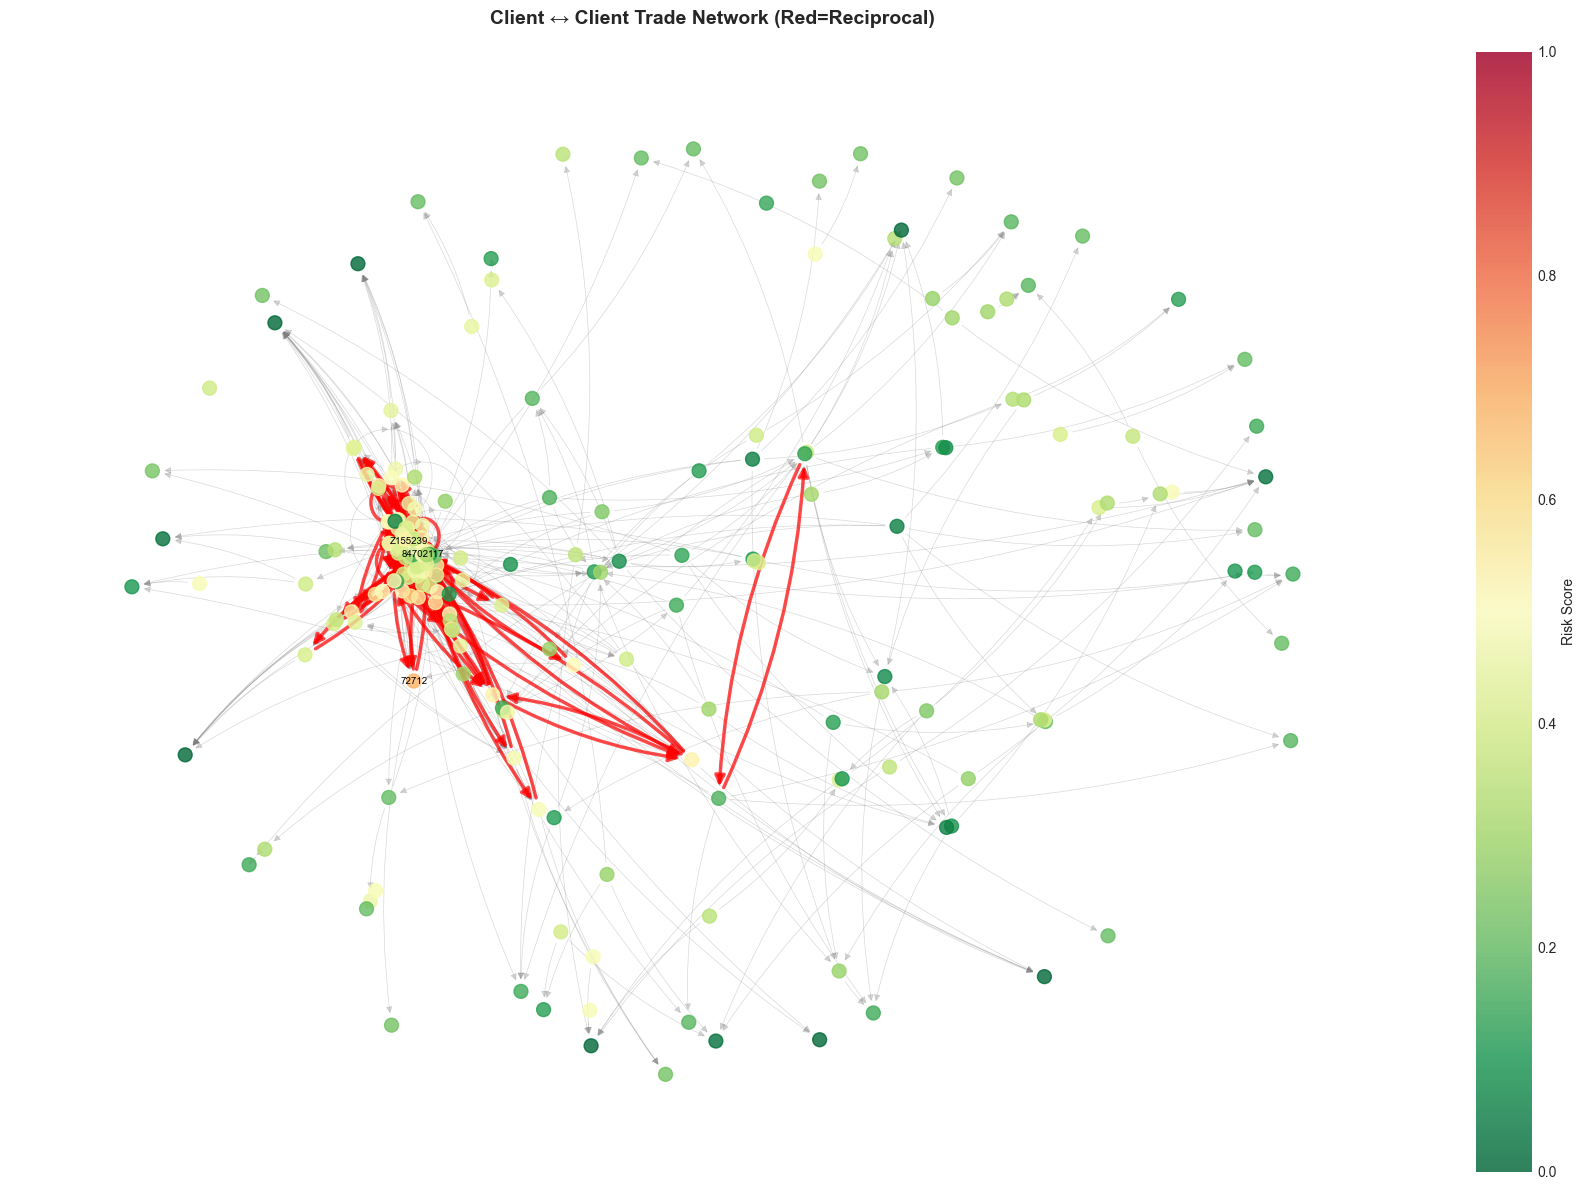


✓ Network visualization complete:
  - Nodes displayed: 250
  - Edges: 839
  - Reciprocal pairs highlighted: 234


In [34]:
def visualize_trade_network(G, client_risk_scores, title="Trade Network - Risk-Colored Nodes"):
    """
    Visualize directed client-to-client trade network.
    - Edge weight = trade quantity
    - Node size = volume traded
    - Node color = risk score
    - Red edges = reciprocal pairs
    - Handle large graphs by filtering top nodes
    """
    
    # Filter for large graphs
    if G.number_of_nodes() > 500:
        print(f"Large graph detected ({G.number_of_nodes()} nodes). Filtering top 250 by volume...")
        node_volumes = {}
        for node in G.nodes():
            out_vol = sum(G[node][succ]['quantity'] for succ in G.successors(node))
            in_vol = sum(G[pred][node]['quantity'] for pred in G.predecessors(node))
            node_volumes[node] = out_vol + in_vol
        
        top_nodes = sorted(node_volumes.items(), key=lambda x: x[1], reverse=True)[:250]
        top_node_set = set([n[0] for n in top_nodes])
        G_filtered = G.subgraph(top_node_set).copy()
    else:
        G_filtered = G.copy()
    
    # Prepare node attributes
    node_sizes = []
    node_colors = []
    
    for node in G_filtered.nodes():
        # Node size = total volume
        volume = sum(G_filtered[node][succ]['quantity'] for succ in G_filtered.successors(node)) + \
                 sum(G_filtered[pred][node]['quantity'] for pred in G_filtered.predecessors(node))
        node_sizes.append(max(100, min(volume / 1000, 2000)))
        
        # Node color = risk score
        if node in client_risk_scores.index:
            node_colors.append(client_risk_scores.loc[node, "CLIENT_RISK_SCORE"])
        else:
            node_colors.append(0.5)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12), dpi=100)
    
    # Layout
    pos = nx.spring_layout(G_filtered, k=2, iterations=50, seed=42)
    
    # Draw edges (normal trades)
    nx.draw_networkx_edges(
        G_filtered, pos,
        width=0.5,
        alpha=0.3,
        edge_color='gray',
        arrows=True,
        arrowsize=10,
        connectionstyle='arc3,rad=0.1',
        ax=ax
    )
    
    # Highlight reciprocal edges in red
    reciprocal_edges = []
    for u, v in G_filtered.edges():
        if G_filtered.has_edge(v, u):
            reciprocal_edges.append((u, v))
    
    nx.draw_networkx_edges(
        G_filtered.edge_subgraph(reciprocal_edges),
        pos,
        width=2.5,
        edge_color='red',
        alpha=0.7,
        arrows=True,
        arrowsize=15,
        connectionstyle='arc3,rad=0.1',
        ax=ax,
        label='Reciprocal Pairs'
    )
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G_filtered, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.RdYlGn_r,
        vmin=0,
        vmax=1,
        alpha=0.8,
        ax=ax
    )
    
    # Add colorbar
    cbar = plt.colorbar(nodes, ax=ax, label='Risk Score', fraction=0.046, pad=0.04)
    
    # Labels (only for high-risk nodes to avoid clutter)
    high_risk_nodes = [n for n in G_filtered.nodes() 
                      if n in client_risk_scores.index and 
                      client_risk_scores.loc[n, "CLIENT_RISK_SCORE"] > 0.6]
    
    labels = {node: node for node in high_risk_nodes[:15]}  # Limit labels
    nx.draw_networkx_labels(G_filtered, pos, labels, font_size=7, ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Network visualization complete:")
    print(f"  - Nodes displayed: {G_filtered.number_of_nodes()}")
    print(f"  - Edges: {G_filtered.number_of_edges()}")
    print(f"  - Reciprocal pairs highlighted: {len(reciprocal_edges)}")


print("\n" + "=" * 80)
print("VIZ 1: CLIENT-TO-CLIENT TRADE NETWORK")
print("=" * 80)

visualize_trade_network(trade_network, client_risk_scores, 
                       "Client ↔ Client Trade Network (Red=Reciprocal)")


### 2️⃣ Community Detection & Clustering


VIZ 2: COMMUNITY DETECTION

✓ Communities detected: 24

Top 3 largest communities:
   1. Community 0: 599 nodes | Sample: ['E23THACKER', 'M15859KD01', '271109', 'Y2455R203', 'V50100695']
   2. Community 1: 474 nodes | Sample: ['89S127', '729D001', 'Z1AC009', '3461', '5702']
   3. Community 2: 393 nodes | Sample: ['X3L1001', 'Z1K127', 'H202V002', 'P11OLK1354', '82201488']


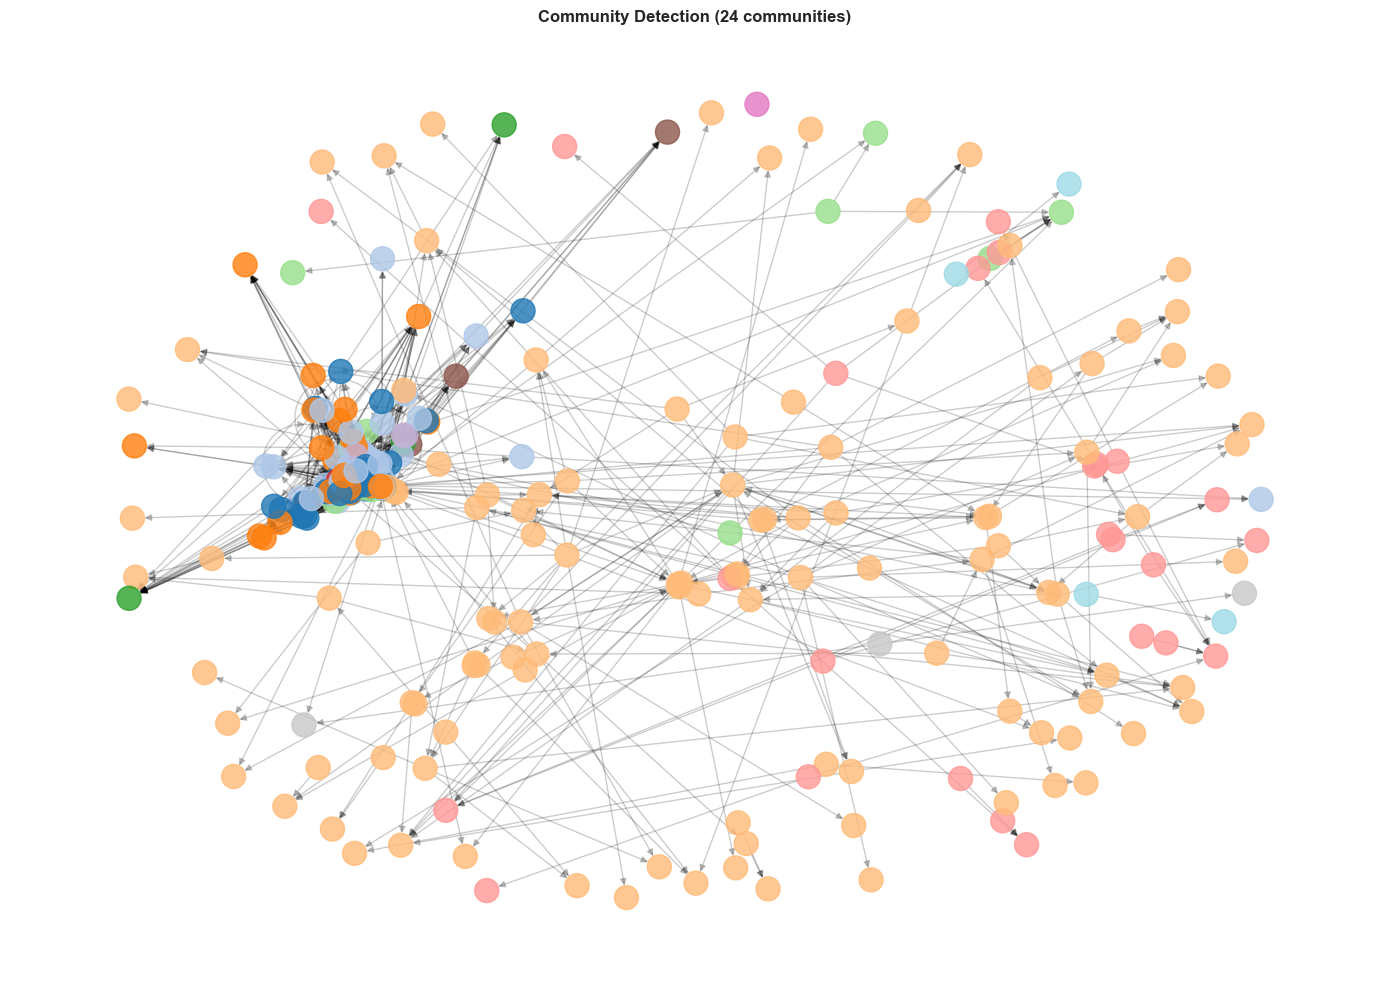

In [35]:
def detect_communities(G, method='greedy'):
    """
    Detect communities using greedy modularity optimization.
    Returns: community assignments and visualization
    """
    from networkx.algorithms import community
    
    # Convert to undirected for community detection
    G_undirected = G.to_undirected()
    
    try:
        # Greedy modularity
        communities_gen = community.greedy_modularity_communities(G_undirected)
        communities = list(communities_gen)
    except Exception as e:
        print(f"Community detection failed: {e}")
        return None, None
    
    # Assign community to each node
    community_map = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            community_map[node] = idx
    
    # Sort by size
    community_sizes = [(idx, len(comm)) for idx, comm in enumerate(communities)]
    community_sizes.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n✓ Communities detected: {len(communities)}")
    print(f"\nTop 3 largest communities:")
    for rank, (comm_idx, size) in enumerate(community_sizes[:3], 1):
        top_nodes = list(communities[comm_idx])[:5]
        print(f"   {rank}. Community {comm_idx}: {size} nodes | Sample: {top_nodes}")
    
    # Visualize communities (filter for readability)
    if G.number_of_nodes() > 500:
        nodes_to_plot = sorted(G.nodes(), 
                              key=lambda x: sum(G[x][s]['quantity'] for s in G.successors(x)) +
                                          sum(G[p][x]['quantity'] for p in G.predecessors(x)),
                              reverse=True)[:300]
        G_plot = G.subgraph(nodes_to_plot).copy()
        community_map_filtered = {k: v for k, v in community_map.items() if k in nodes_to_plot}
    else:
        G_plot = G.copy()
        community_map_filtered = community_map
    
    # Draw
    fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
    pos = nx.spring_layout(G_plot, k=2, iterations=50, seed=42)
    
    # Color by community
    node_colors = [community_map_filtered.get(node, -1) for node in G_plot.nodes()]
    
    nx.draw_networkx_edges(G_plot, pos, alpha=0.2, arrows=True, ax=ax)
    nodes = nx.draw_networkx_nodes(G_plot, pos, node_color=node_colors, 
                                    cmap=plt.cm.tab20, node_size=300, 
                                    ax=ax, alpha=0.8)
    
    ax.set_title(f"Community Detection ({len(communities)} communities)", 
                fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return community_map, communities


print("\n" + "=" * 80)
print("VIZ 2: COMMUNITY DETECTION")
print("=" * 80)

community_map, communities_list = detect_communities(trade_network)


### 3️⃣ Reciprocity & Counterparty Concentration Heatmap


VIZ 3: RECIPROCITY & CONCENTRATION HEATMAPS


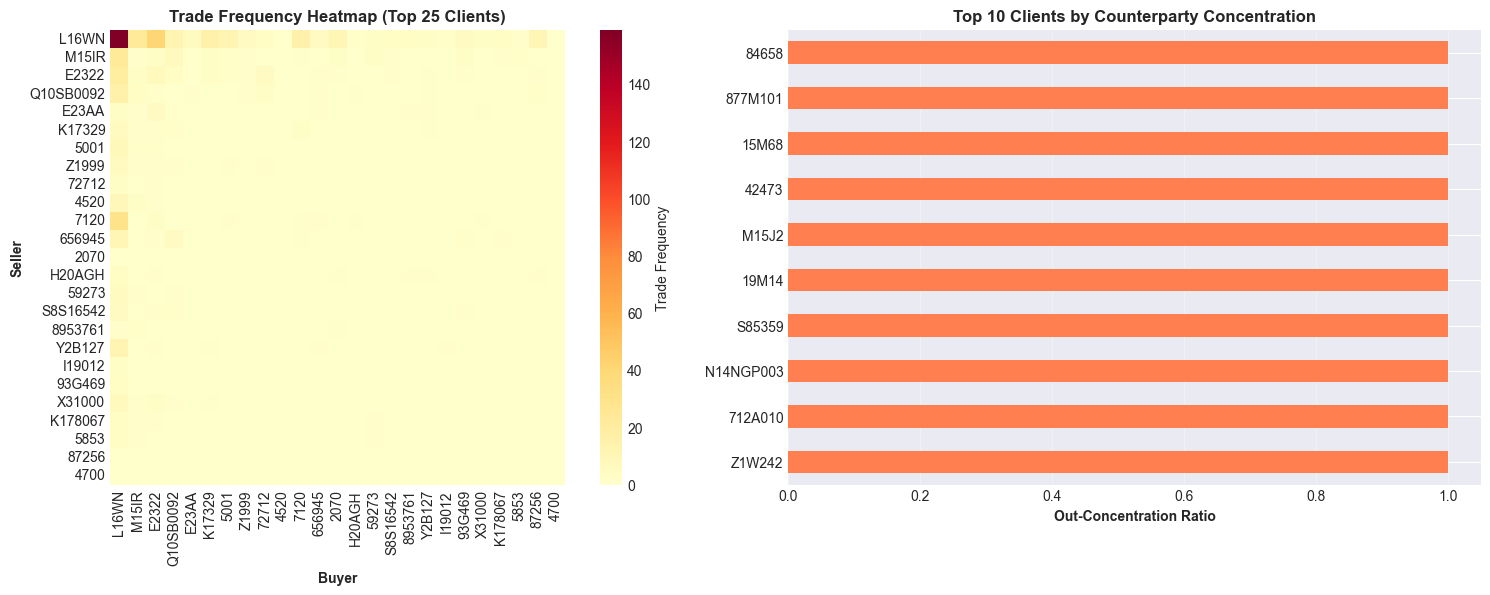


✓ Heatmap Analysis:
  - Top 25 nodes analyzed
  - Reciprocal pairs: 40


In [36]:
def visualize_reciprocity_heatmap(G, client_network_metrics, top_n=30):
    """
    Visualize reciprocity and concentration as heatmap + bar plots.
    Shows client-to-client trade frequency and concentration.
    """
    
    # Get top nodes by degree
    top_nodes = sorted(G.nodes(), 
                      key=lambda x: G.degree(x), 
                      reverse=True)[:top_n]
    
    # Create adjacency matrix (trade frequency)
    adj_matrix = np.zeros((len(top_nodes), len(top_nodes)))
    for i, u in enumerate(top_nodes):
        for j, v in enumerate(top_nodes):
            if G.has_edge(u, v):
                adj_matrix[i, j] = G[u][v]['trades']
    
    # Heatmap
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
    
    # Trade frequency heatmap
    sns.heatmap(adj_matrix, xticklabels=top_nodes, yticklabels=top_nodes, 
                cmap='YlOrRd', cbar_kws={'label': 'Trade Frequency'},
                ax=axes[0], square=True)
    axes[0].set_title(f'Trade Frequency Heatmap (Top {top_n} Clients)', 
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Buyer', fontweight='bold')
    axes[0].set_ylabel('Seller', fontweight='bold')
    
    # Concentration bar plot (Top 10 by concentration)
    conc_data = client_network_metrics.nlargest(10, 'OUT_CONCENTRATION')[['OUT_CONCENTRATION']]
    conc_data['OUT_CONCENTRATION'].plot(kind='barh', ax=axes[1], color='coral')
    axes[1].set_xlabel('Out-Concentration Ratio', fontweight='bold')
    axes[1].set_title('Top 10 Clients by Counterparty Concentration', 
                     fontsize=12, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Heatmap Analysis:")
    print(f"  - Top {top_n} nodes analyzed")
    print(f"  - Reciprocal pairs: {sum(1 for i in range(len(top_nodes)) for j in range(len(top_nodes)) if i != j and adj_matrix[i,j] > 0 and adj_matrix[j,i] > 0) // 2}")


print("\n" + "=" * 80)
print("VIZ 3: RECIPROCITY & CONCENTRATION HEATMAPS")
print("=" * 80)

visualize_reciprocity_heatmap(trade_network, client_network_metrics, top_n=25)


### 4️⃣ Circular Loop Detection Visualization


VIZ 4: CIRCULAR LOOP DETECTION


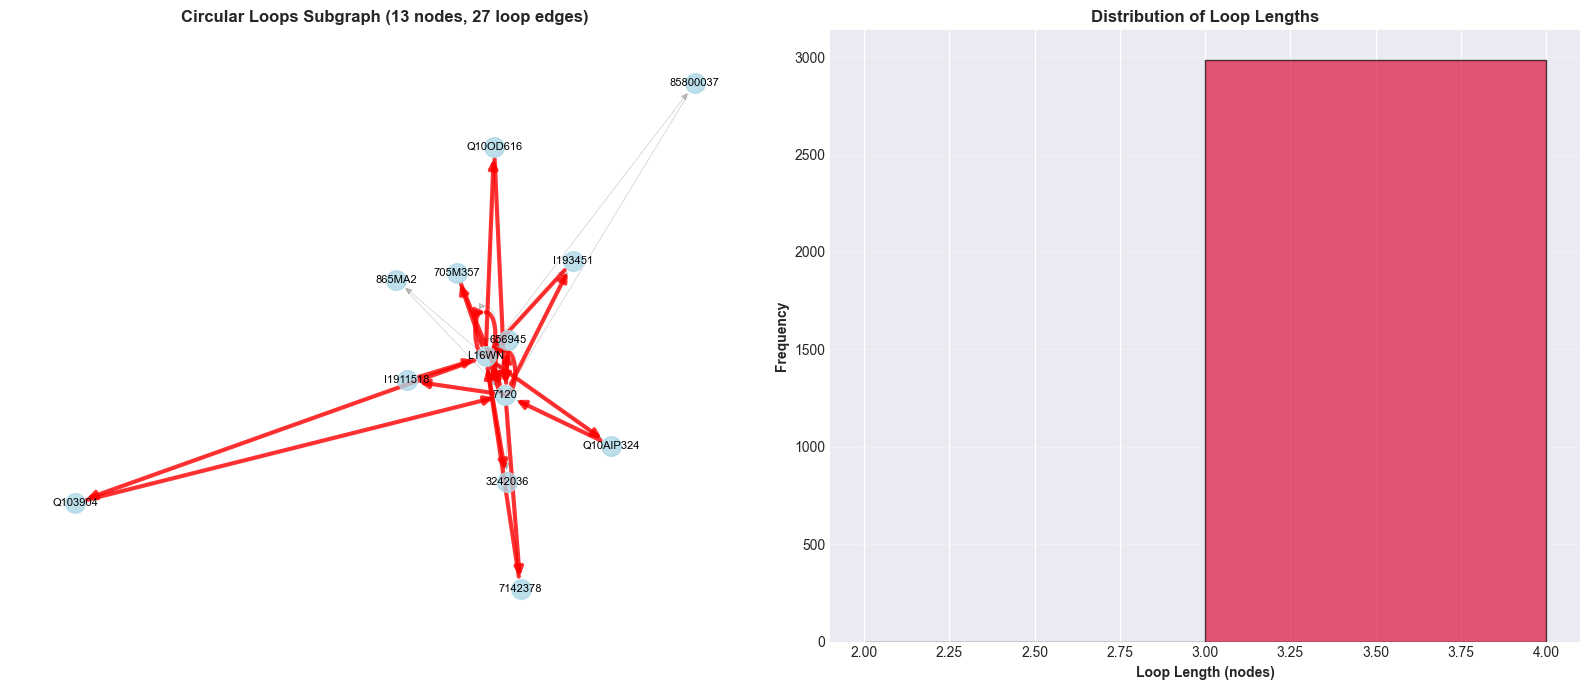


✓ Circular Loop Analysis:
  - Total loops detected: 2988
  - Loops visualized: 15
  - Loop edge count: 27

Loop Length Distribution:
   - Length 3: 2988 loops


In [37]:
def visualize_circular_loops(G, loops_list, max_loops_display=15):
    """
    Visualize circular loops with red highlighted edges.
    Detects and highlights loops of length 2-4.
    """
    
    # Create loop edges set
    loop_edges = set()
    for loop in loops_list[:max_loops_display]:
        for i in range(len(loop)):
            u, v = loop[i], loop[(i + 1) % len(loop)]
            loop_edges.add((u, v))
    
    # Build subgraph of loop nodes
    loop_nodes = set()
    for loop in loops_list[:max_loops_display]:
        loop_nodes.update(loop)
    
    G_loops = G.subgraph(loop_nodes).copy()
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi=100)
    
    # Plot 1: Full network with loop edges highlighted
    pos = nx.spring_layout(G_loops, k=2, iterations=50, seed=42)
    
    # Normal edges
    nx.draw_networkx_edges(G_loops, pos, width=0.5, alpha=0.2, ax=axes[0])
    
    # Loop edges in red
    loop_edge_list = [(u, v) for u, v in G_loops.edges() if (u, v) in loop_edges]
    nx.draw_networkx_edges(G_loops, pos, edgelist=loop_edge_list, 
                          width=3, edge_color='red', alpha=0.8, ax=axes[0],
                          arrows=True, arrowsize=12)
    
    # Nodes
    nx.draw_networkx_nodes(G_loops, pos, node_size=200, node_color='lightblue', 
                          alpha=0.8, ax=axes[0])
    nx.draw_networkx_labels(G_loops, pos, font_size=8, ax=axes[0])
    
    axes[0].set_title(f'Circular Loops Subgraph ({len(loop_nodes)} nodes, {len(loop_edges)} loop edges)', 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Plot 2: Loop statistics
    loop_lengths = [len(loop) for loop in loops_list]
    ax2 = axes[1]
    ax2.hist(loop_lengths, bins=range(2, max(loop_lengths)+2), color='crimson', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Loop Length (nodes)', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title('Distribution of Loop Lengths', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Circular Loop Analysis:")
    print(f"  - Total loops detected: {len(loops_list)}")
    print(f"  - Loops visualized: {min(max_loops_display, len(loops_list))}")
    print(f"  - Loop edge count: {len(loop_edges)}")
    print(f"\nLoop Length Distribution:")
    for length in sorted(set(loop_lengths)):
        count = sum(1 for l in loop_lengths if l == length)
        print(f"   - Length {length}: {count} loops")


print("\n" + "=" * 80)
print("VIZ 4: CIRCULAR LOOP DETECTION")
print("=" * 80)

visualize_circular_loops(trade_network, loops)


### 6️⃣ Price & Volume Behavior


VIZ 6: PRICE & VOLUME BEHAVIOR

✓ Plotting price and volume behavior for flagged scrips...


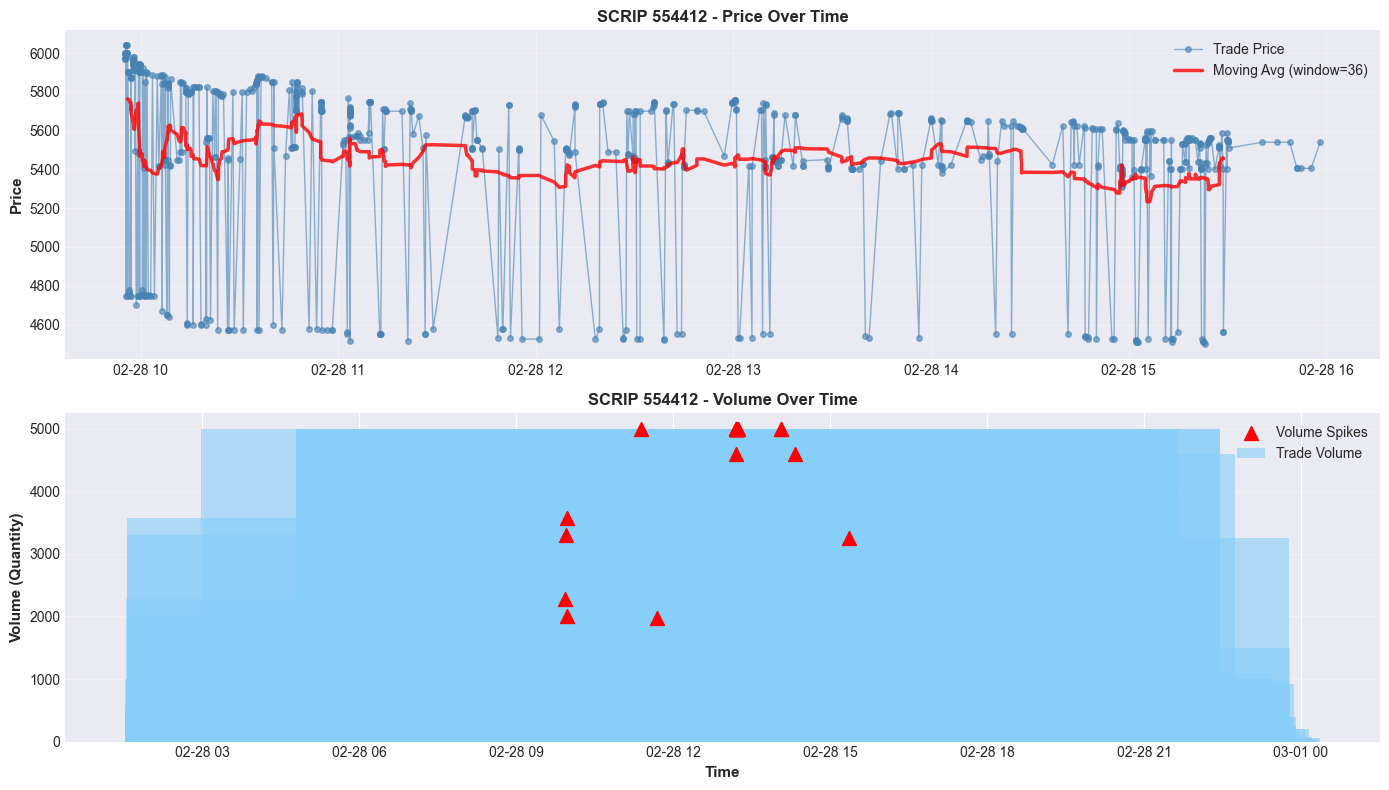


  Scrip 554412:
    - Trades: 737
    - Volume spikes detected: 20
    - Price range: 4500.00 - 6040.00


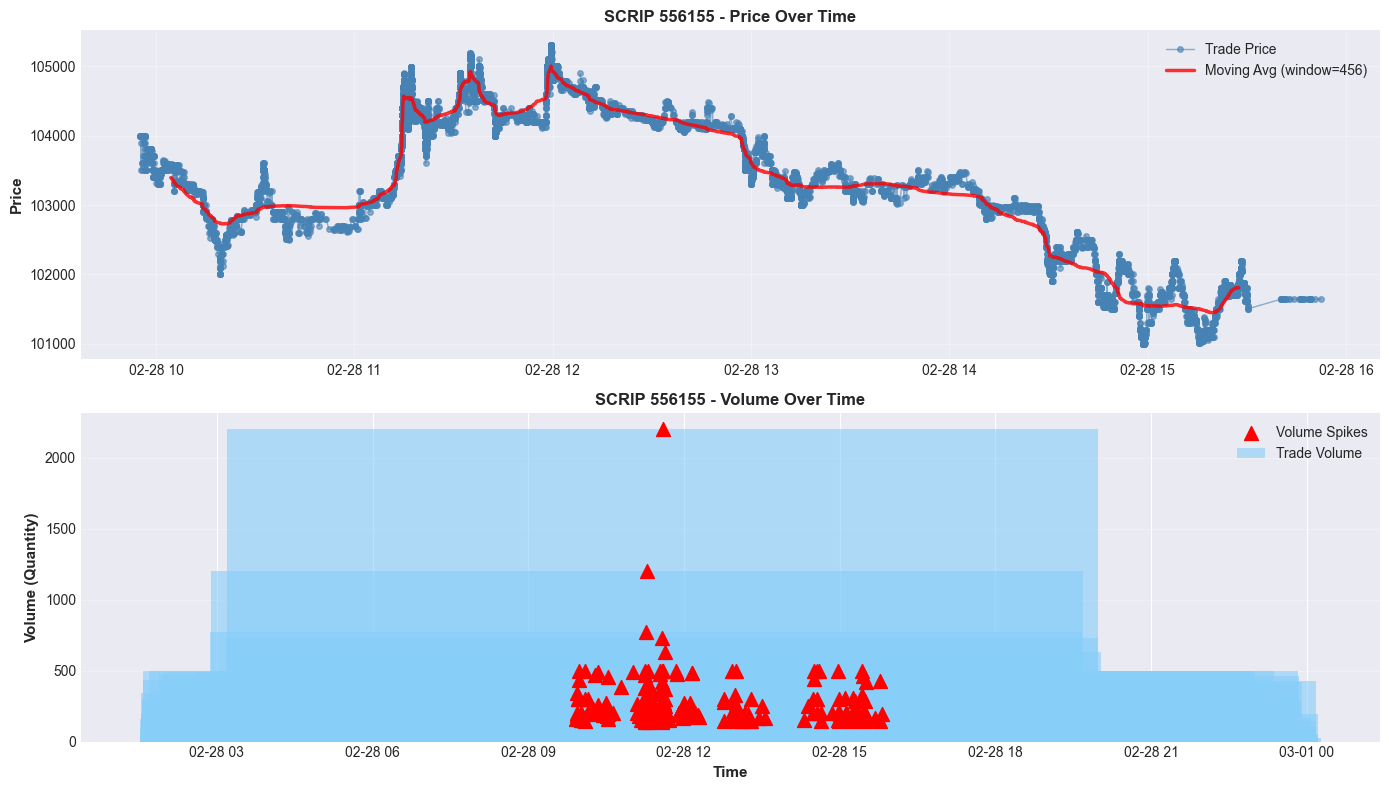


  Scrip 556155:
    - Trades: 9134
    - Volume spikes detected: 257
    - Price range: 101000.00 - 105300.00


In [39]:
def plot_price_volume_behavior(trades_df, suspicious_scrips):
    """
    Plot price and volume behavior for each flagged scrip.
    Show trends, abnormal spikes, and rolling averages.
    """
    
    print("\n✓ Plotting price and volume behavior for flagged scrips...")
    
    for scrip in suspicious_scrips:
        scrip_trades = trades_df[trades_df["SCRIP_CODE"] == scrip].sort_values("TRADE_TIME").copy()
        
        if len(scrip_trades) < 2:
            continue
        
        scrip_trades["TRADE_TIME"] = pd.to_datetime(scrip_trades["TRADE_TIME"], errors='coerce')
        scrip_trades_time = scrip_trades.set_index("TRADE_TIME").sort_index()
        
        # Compute rolling average (window = 5% of trades)
        window = max(1, len(scrip_trades) // 20)
        scrip_trades_time['PRICE_MA'] = scrip_trades_time['TRADE_RATE'].rolling(window=window, center=True).mean()
        
        # Detect spikes (volume > 2 std)
        mean_vol = scrip_trades_time['TRADE_QUANTITY'].mean()
        std_vol = scrip_trades_time['TRADE_QUANTITY'].std()
        spikes = scrip_trades_time[scrip_trades_time['TRADE_QUANTITY'] > mean_vol + 2*std_vol]
        
        # Plots
        fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=100)
        
        # Price plot with MA
        axes[0].plot(scrip_trades_time.index, scrip_trades_time['TRADE_RATE'], 
                    'o-', linewidth=1, markersize=4, alpha=0.6, label='Trade Price', color='steelblue')
        axes[0].plot(scrip_trades_time.index, scrip_trades_time['PRICE_MA'], 
                    'r-', linewidth=2.5, label=f'Moving Avg (window={window})', alpha=0.8)
        axes[0].set_ylabel('Price', fontweight='bold', fontsize=11)
        axes[0].set_title(f'SCRIP {scrip} - Price Over Time', fontsize=12, fontweight='bold')
        axes[0].legend(loc='best')
        axes[0].grid(alpha=0.3)
        
        # Volume plot with spike markers
        axes[1].bar(scrip_trades_time.index, scrip_trades_time['TRADE_QUANTITY'], 
                   width=0.7, alpha=0.6, color='lightskyblue', label='Trade Volume')
        
        if len(spikes) > 0:
            axes[1].scatter(spikes.index, spikes['TRADE_QUANTITY'], 
                           color='red', s=100, marker='^', label='Volume Spikes', zorder=5)
        
        axes[1].set_xlabel('Time', fontweight='bold', fontsize=11)
        axes[1].set_ylabel('Volume (Quantity)', fontweight='bold', fontsize=11)
        axes[1].set_title(f'SCRIP {scrip} - Volume Over Time', fontsize=12, fontweight='bold')
        axes[1].legend(loc='best')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n  Scrip {scrip}:")
        print(f"    - Trades: {len(scrip_trades)}")
        print(f"    - Volume spikes detected: {len(spikes)}")
        print(f"    - Price range: {scrip_trades_time['TRADE_RATE'].min():.2f} - {scrip_trades_time['TRADE_RATE'].max():.2f}")


print("\n" + "=" * 80)
print("VIZ 6: PRICE & VOLUME BEHAVIOR")
print("=" * 80)

plot_price_volume_behavior(trades_df, flagged_scrips)


### 7️⃣ Risk Score Heatmaps


VIZ 7: RISK SCORE HEATMAPS


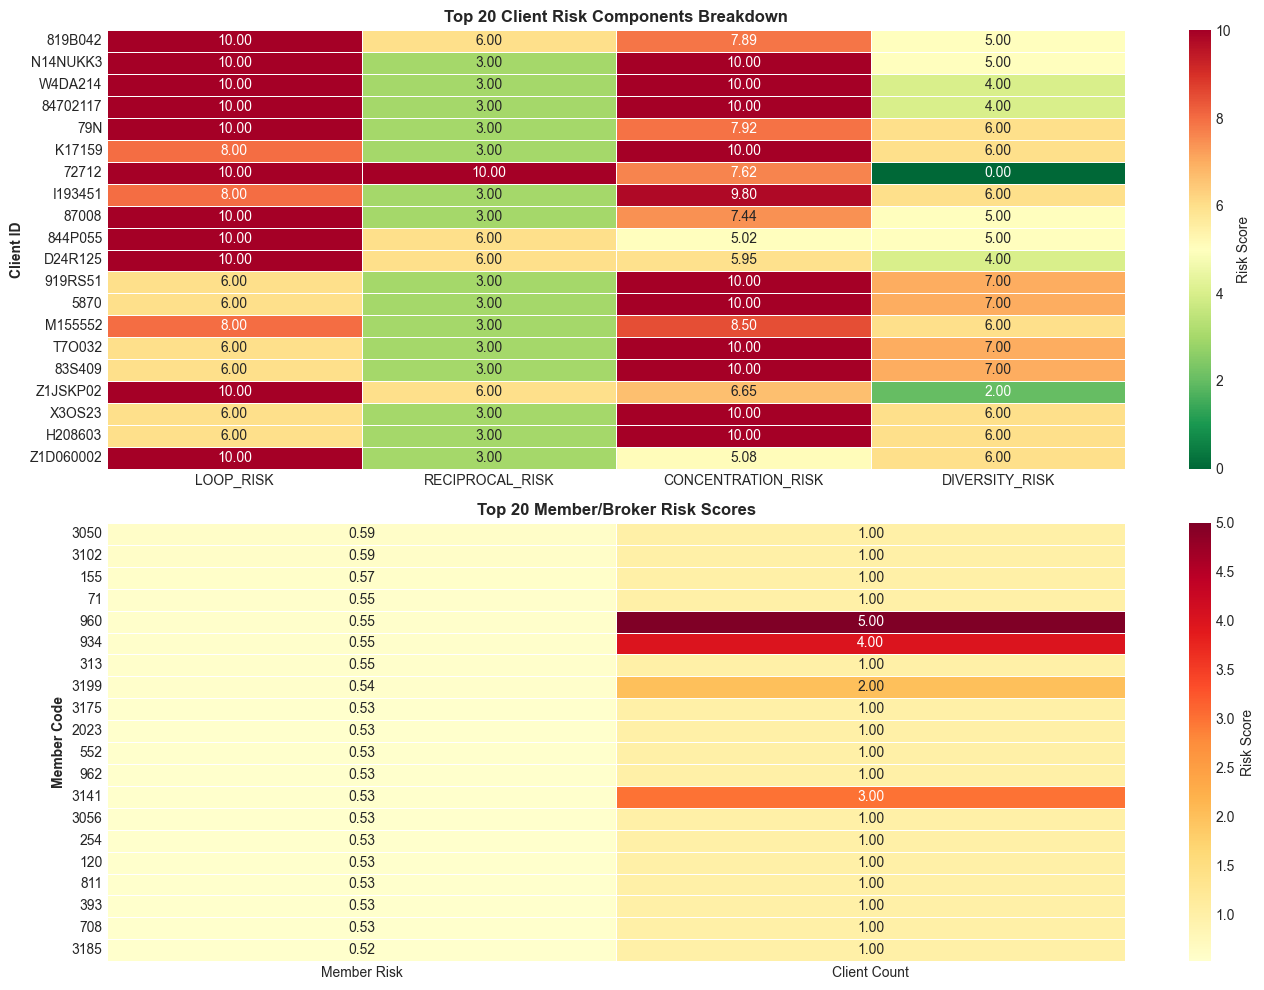

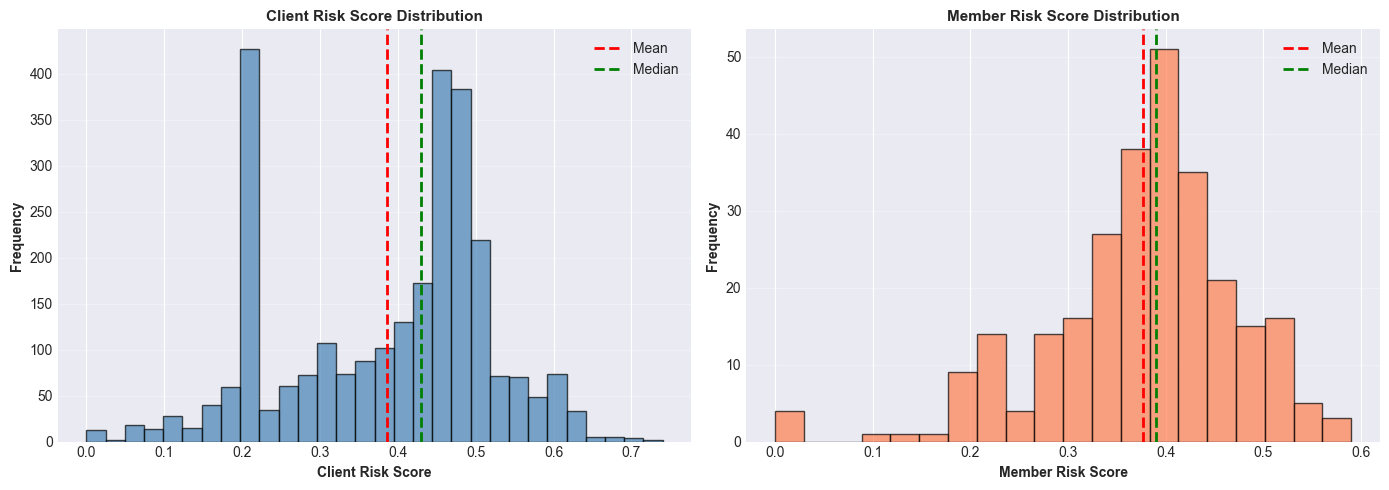


✓ Risk Heatmap Summary:
  - Client risks plotted: 20
  - Member risks plotted: 20
  - High-risk clients (>0.7): 5
  - High-risk members (>0.6): 0


In [40]:
def plot_risk_heatmaps(client_risk_scores, member_risk_scores, top_n=20):
    """
    Plot heatmaps showing client and member risk score distributions.
    Visualize risk components breakdown.
    """
    
    # Client risk scores (top N)
    top_clients = client_risk_scores.nlargest(top_n, 'CLIENT_RISK_SCORE')
    risk_components = top_clients[['LOOP_RISK', 'RECIPROCAL_RISK', 'CONCENTRATION_RISK', 'DIVERSITY_RISK']]
    
    # Member risk scores (top N)
    top_members = member_risk_scores.nlargest(top_n, 'MEMBER_RISK_SCORE')
    
    # Heatmaps
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100)
    
    # Client risk components heatmap
    sns.heatmap(risk_components, annot=True, fmt='.2f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'Risk Score'}, ax=axes[0], 
                vmin=0, vmax=10, linewidths=0.5)
    axes[0].set_title(f'Top {top_n} Client Risk Components Breakdown', 
                     fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Client ID', fontweight='bold')
    axes[0].set_xlabel('')
    
    # Member risk heatmap
    member_risk_matrix = top_members[['MEMBER_RISK_SCORE', 'CLIENT_COUNT']].copy()
    member_risk_matrix.columns = ['Member Risk', 'Client Count']
    
    sns.heatmap(member_risk_matrix, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Risk Score'}, ax=axes[1],
                linewidths=0.5)
    axes[1].set_title(f'Top {top_n} Member/Broker Risk Scores', 
                     fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Member Code', fontweight='bold')
    axes[1].set_xlabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Risk distribution
    fig, axes_dist = plt.subplots(1, 2, figsize=(14, 5), dpi=100)
    
    # Client risk distribution with annotations
    axes_dist[0].hist(client_risk_scores['CLIENT_RISK_SCORE'], bins=30, 
                     color='steelblue', alpha=0.7, edgecolor='black')
    axes_dist[0].axvline(client_risk_scores['CLIENT_RISK_SCORE'].mean(), 
                        color='red', linestyle='--', linewidth=2, label='Mean')
    axes_dist[0].axvline(client_risk_scores['CLIENT_RISK_SCORE'].median(), 
                        color='green', linestyle='--', linewidth=2, label='Median')
    axes_dist[0].set_xlabel('Client Risk Score', fontweight='bold')
    axes_dist[0].set_ylabel('Frequency', fontweight='bold')
    axes_dist[0].set_title('Client Risk Score Distribution', fontsize=11, fontweight='bold')
    axes_dist[0].legend()
    axes_dist[0].grid(axis='y', alpha=0.3)
    
    # Member risk distribution
    axes_dist[1].hist(member_risk_scores['MEMBER_RISK_SCORE'], bins=20, 
                     color='coral', alpha=0.7, edgecolor='black')
    axes_dist[1].axvline(member_risk_scores['MEMBER_RISK_SCORE'].mean(), 
                        color='red', linestyle='--', linewidth=2, label='Mean')
    axes_dist[1].axvline(member_risk_scores['MEMBER_RISK_SCORE'].median(), 
                        color='green', linestyle='--', linewidth=2, label='Median')
    axes_dist[1].set_xlabel('Member Risk Score', fontweight='bold')
    axes_dist[1].set_ylabel('Frequency', fontweight='bold')
    axes_dist[1].set_title('Member Risk Score Distribution', fontsize=11, fontweight='bold')
    axes_dist[1].legend()
    axes_dist[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Risk Heatmap Summary:")
    print(f"  - Client risks plotted: {len(top_clients)}")
    print(f"  - Member risks plotted: {len(top_members)}")
    print(f"  - High-risk clients (>0.7): {(client_risk_scores['CLIENT_RISK_SCORE'] > 0.7).sum()}")
    print(f"  - High-risk members (>0.6): {(member_risk_scores['MEMBER_RISK_SCORE'] > 0.6).sum()}")


print("\n" + "=" * 80)
print("VIZ 7: RISK SCORE HEATMAPS")
print("=" * 80)

plot_risk_heatmaps(client_risk_scores, member_risk_scores, top_n=20)


### 8️⃣ Infrastructure-Linked Network (Bonus)

In [ ]:
def visualize_infrastructure_linked_network(infra_clusters, client_risk_scores):
    """
    Visualize infrastructure-linked clusters.
    Show clients sharing terminals, locations, or members separately.
    """
    
    print("\n✓ Visualizing infrastructure-linked networks...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)
    
    # 1. Terminal clusters
    terminal_graph = nx.Graph()
    for terminal, clients in infra_clusters['TERMINAL_CLUSTERS'].items():
        if len(clients) > 1:
            for i, client1 in enumerate(clients):
                for client2 in clients[i+1:]:
                    risk1 = client_risk_scores.loc[client1, 'CLIENT_RISK_SCORE'] if client1 in client_risk_scores.index else 0
                    risk2 = client_risk_scores.loc[client2, 'CLIENT_RISK_SCORE'] if client2 in client_risk_scores.index else 0
                    avg_risk = (risk1 + risk2) / 2
                    terminal_graph.add_edge(client1, client2, terminal=terminal, risk=avg_risk)
    
    if len(terminal_graph.nodes()) > 0:
        pos_term = nx.spring_layout(terminal_graph, k=2, seed=42)
        node_colors_term = [client_risk_scores.loc[n, 'CLIENT_RISK_SCORE'] if n in client_risk_scores.index else 0.5 
                           for n in terminal_graph.nodes()]
        nx.draw_networkx_edges(terminal_graph, pos_term, alpha=0.3, ax=axes[0], width=0.5)
        nodes = nx.draw_networkx_nodes(terminal_graph, pos_term, node_color=node_colors_term, 
                                       cmap='RdYlGn_r', node_size=200, alpha=0.8, ax=axes[0], vmin=0, vmax=1)
        axes[0].set_title(f'Terminal-Shared Clusters ({len(infra_clusters["TERMINAL_CLUSTERS"])} terminals)', 
                         fontsize=11, fontweight='bold')
        axes[0].axis('off')
    
    # 2. Location clusters (sample top 10)
    location_graph = nx.Graph()
    top_locations = sorted(infra_clusters['LOCATION_CLUSTERS'].items(), 
                          key=lambda x: len(x[1]), reverse=True)[:10]
    for location, clients in top_locations:
        if len(clients) > 1:
            for i, client1 in enumerate(clients):
                for client2 in clients[i+1:]:
                    risk1 = client_risk_scores.loc[client1, 'CLIENT_RISK_SCORE'] if client1 in client_risk_scores.index else 0
                    risk2 = client_risk_scores.loc[client2, 'CLIENT_RISK_SCORE'] if client2 in client_risk_scores.index else 0
                    avg_risk = (risk1 + risk2) / 2
                    location_graph.add_edge(client1, client2, location=location, risk=avg_risk)
    
    if len(location_graph.nodes()) > 0:
        pos_loc = nx.spring_layout(location_graph, k=2, seed=42)
        node_colors_loc = [client_risk_scores.loc[n, 'CLIENT_RISK_SCORE'] if n in client_risk_scores.index else 0.5 
                          for n in location_graph.nodes()]
        nx.draw_networkx_edges(location_graph, pos_loc, alpha=0.3, ax=axes[1], width=0.5)
        nodes = nx.draw_networkx_nodes(location_graph, pos_loc, node_color=node_colors_loc, 
                                       cmap='RdYlGn_r', node_size=200, alpha=0.8, ax=axes[1], vmin=0, vmax=1)
        axes[1].set_title(f'Location-Shared Clusters (Top 10)', fontsize=11, fontweight='bold')
        axes[1].axis('off')
    
    # 3. Member clusters
    member_graph = nx.Graph()
    for member, clients in infra_clusters['MEMBER_CLUSTERS'].items():
        if len(clients) > 1:
            for i, client1 in enumerate(clients):
                for client2 in clients[i+1:]:
                    risk1 = client_risk_scores.loc[client1, 'CLIENT_RISK_SCORE'] if client1 in client_risk_scores.index else 0
                    risk2 = client_risk_scores.loc[client2, 'CLIENT_RISK_SCORE'] if client2 in client_risk_scores.index else 0
                    avg_risk = (risk1 + risk2) / 2
                    member_graph.add_edge(client1, client2, member=member, risk=avg_risk)
    
    if len(member_graph.nodes()) > 0:
        pos_mem = nx.spring_layout(member_graph, k=2, seed=42)
        node_colors_mem = [client_risk_scores.loc[n, 'CLIENT_RISK_SCORE'] if n in client_risk_scores.index else 0.5 
                          for n in member_graph.nodes()]
        nx.draw_networkx_edges(member_graph, pos_mem, alpha=0.3, ax=axes[2], width=0.5)
        nodes = nx.draw_networkx_nodes(member_graph, pos_mem, node_color=node_colors_mem, 
                                       cmap='RdYlGn_r', node_size=200, alpha=0.8, ax=axes[2], vmin=0, vmax=1)
        plt.colorbar(nodes, ax=axes[2], label='Risk Score')
        axes[2].set_title(f'Member-Shared Clusters ({len(infra_clusters["MEMBER_CLUSTERS"])} members)', 
                         fontsize=11, fontweight='bold')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Infrastructure Linkage Visualization:")
    print(f"  - Terminal-based clusters: {len(infra_clusters['TERMINAL_CLUSTERS'])}")
    print(f"  - Location-based clusters: {len(infra_clusters['LOCATION_CLUSTERS'])}")
    print(f"  - Member-based clusters: {len(infra_clusters['MEMBER_CLUSTERS'])}")


def plot_top_client_pairs(infra_clusters, client_risk_scores, top_n=10):
    """
    Plot top client pairs sharing infrastructure.
    """
    
    print("\n✓ Analyzing top client pairs sharing infrastructure...")
    
    pair_risk = defaultdict(float)
    pair_infra = defaultdict(list)
    
    # Collect all shared infrastructure pairs
    for cluster_type, clusters in infra_clusters.items():
        for key, clients in clusters.items():
            if len(clients) > 1:
                for i, client1 in enumerate(clients):
                    for client2 in clients[i+1:]:
                        pair = tuple(sorted([client1, client2]))
                        risk1 = client_risk_scores.loc[client1, 'CLIENT_RISK_SCORE'] if client1 in client_risk_scores.index else 0
                        risk2 = client_risk_scores.loc[client2, 'CLIENT_RISK_SCORE'] if client2 in client_risk_scores.index else 0
                        pair_risk[pair] = max(pair_risk[pair], (risk1 + risk2) / 2)
                        pair_infra[pair].append(cluster_type.replace('_CLUSTERS', '').lower())
    
    # Get top pairs
    top_pairs = sorted(pair_risk.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    if top_pairs:
        clients_pair = [f"{p[0][0][:8]}-{p[0][1][:8]}" for p in top_pairs]
        risks_pair = [p[1] for p in top_pairs]
        infra_list = ['; '.join(set(pair_infra[p[0]])) for p in top_pairs]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.barh(range(len(clients_pair)), risks_pair, color='crimson', alpha=0.7)
        ax.set_yticks(range(len(clients_pair)))
        ax.set_yticklabels(clients_pair, fontsize=9)
        ax.set_xlabel('Average Risk Score', fontweight='bold')
        ax.set_title(f'Top {top_n} Client Pairs Sharing Infrastructure', fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Add infrastructure type labels
        for i, (bar, infra) in enumerate(zip(bars, infra_list)):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                   infra, va='center', fontsize=8, style='italic')
        
        plt.tight_layout()
        plt.show()


print("\n" + "=" * 80)
print("VIZ 8: INFRASTRUCTURE-LINKED NETWORKS")
print("=" * 80)

visualize_infrastructure_linked_network(infra_clusters, client_risk_scores)
plot_top_client_pairs(infra_clusters, client_risk_scores, top_n=12)

print("\n✓ All network visualizations complete!")



VIZ 8: INFRASTRUCTURE-LINKED NETWORKS

✓ Visualizing infrastructure-linked networks...
